In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00


# Preprocessing and Feature Selection

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

class Preprocessor:
    def __init__(self, train_data,pool_data, test_data):
        self.train_data = train_data.copy()
        self.pool_data = pool_data.copy()
        self.test_data = test_data.copy()
        self.label_encoders = {}


    def handle_missing_values(self):
      drop_cols = ["Census_IsWIMBootEnabled","Census_ThresholdOptIn","Census_IsFlightingInternal","Census_InternalBatteryType",
                        "Census_ProcessorClass","PuaMode","DefaultBrowsersIdentifier","SmartScreen","OrganizationIdentifier"]
      self.train_data = self.train_data.drop(columns = drop_cols, axis = 1)
      self.test_data = self.test_data.drop(columns = drop_cols, axis = 1)
      self.pool_data = self.pool_data.drop(columns = drop_cols, axis = 1)


      categorical_cols =  self.train_data.select_dtypes(include=['object']).columns.tolist()
      for col in categorical_cols:
          fill_value = self.train_data[col].mode()[0]
          self.train_data[col].fillna(fill_value, inplace=True)
          self.test_data[col].fillna(fill_value, inplace=True)
          self.pool_data[col].fillna(fill_value, inplace=True)


      numerical_cols = [col for col in self.train_data.columns if col not in categorical_cols and col != 'HasDetections']
      for col in numerical_cols:
          fill_value = self.train_data[col].mean()
          self.train_data[col].fillna(fill_value, inplace=True)
          self.test_data[col].fillna(fill_value, inplace=True)
          self.pool_data[col].fillna(fill_value, inplace=True)



    def normalize_data(self):

        cols = self.train_data.columns.to_list()
        if 'HasDetections' in cols:
            cols.remove('HasDetections')

        self.scaler = StandardScaler()

        self.train_data[cols] = self.scaler.fit_transform(self.train_data[cols])

        self.test_data[cols] = self.scaler.transform(self.test_data[cols])

        self.pool_data[cols] = self.scaler.transform(self.pool_data[cols])



    def hash_encode_categorical_columns(self):
            self.categorical_cols = self.train_data.select_dtypes(include=['object']).columns.tolist()

            for col in self.categorical_cols:

                hash_function = lambda x: hash(x) % 10

                self.train_data[col] = self.train_data[col].apply(hash_function)
                self.pool_data[col] = self.pool_data[col].apply(hash_function)

                self.test_data[col] = self.test_data[col].apply(hash_function)


    def feature_selection(self):
      y = self.train_data['HasDetections']
      X = self.train_data.drop('HasDetections', axis=1)
      model = XGBClassifier()

      model.fit(X, y)

      importance = model.feature_importances_

      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

      column_names = X.columns

      feature_importance_df = pd.DataFrame({
          'Feature': column_names,
          'Importance': importance
      })

      feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
      drop_cols = feature_importance_df[feature_importance_df["Importance"] == 0]["Feature"].to_list()

      self.train_data = self.train_data.drop(columns = drop_cols, axis = 1)
      self.test_data = self.test_data.drop(columns = drop_cols, axis = 1)
      self.pool_data = self.pool_data.drop(columns = drop_cols, axis = 1)

    def preprocess(self):
        self.hash_encode_categorical_columns()
        self.handle_missing_values()
        self.normalize_data()
        self.feature_selection()
        return self.train_data,self.pool_data, self.test_data


In [ ]:
data = pd.read_csv("train.csv.zip", nrows=100000)

train_ratio = 0.25
pool_ratio = 0.66
test_ratio = 0.34

labels = data['HasDetections']
data = data.drop('HasDetections', axis=1)

data_train, data_remaining, labels_train, labels_remaining = train_test_split(data, labels, test_size=(1 - train_ratio), random_state=42)
data_pool, data_test, labels_pool, labels_test = train_test_split(data_remaining, labels_remaining, test_size=test_ratio, random_state=42)

data_train['HasDetections'] = labels_train
data_pool['HasDetections'] = labels_pool
data_test['HasDetections'] = labels_test

preprocessor = Preprocessor(data_train, data_pool,data_test)
train_processed, pool_processed, test_processed = preprocessor.preprocess()

print(train_processed.info())
print(pool_processed.info())
print(test_processed.info())

train_processed.to_csv('Malware Prediction/dataset/train_processed.csv', index=False)
test_processed.to_csv('Malware Prediction/dataset/test_processed.csv', index=False)
pool_processed.to_csv('Malware Prediction/dataset/pool_processed.csv', index=False)

# Design and Implementation
## Active Learner Class
 is designed to facilitate an active learning process. Active learning is a machine learning paradigm where the algorithm interactively queries the user or an oracle to obtain labels for new data points, aiming to improve the model's performance with minimal labeling effort.

* Class Initialization:

> The ActiveLearner class is initialized with several parameters:
* model: Machine learning model (presumably scikit-learn compatible).
* X_train, y_train: Training data (features and labels).
* X_pool, y_pool: Pool of unlabeled data (features and labels).
* X_test, y_test: Test data (features and labels).

* Methods:


> active_learning: This method conducts the active learning process. It trains the model initially and then iterates through a certain number of iterations (itterations) or until the pool of unlabeled data is exhausted. The active learning method is specified by method (default: "ENT_UNC"). It uses different query strategies like uncertainty sampling based on entropy (UNC_entropy), marginal sampling (UNC_marginal), or query by committee (query_by_committee).


> * UNC_entropy: Selects data points with the highest uncertainty based on entropy.
> * UNC_marginal: Selects data points where the model is most uncertain between class probabilities.
> * query_by_committee: Implements a committee of models to select uncertain data points using a voting/aggregation mechanism.

* Data Handling:

> The code updates the training and pool data by adding queried samples to the training set and removing them from the pool.
After each iteration, it evaluates the model's performance metrics (accuracy, F1-score, precision, recall) on the test data and stores these metrics along with the size of the training and pool sets.

* Evaluation and Results:

> Performance metrics such as accuracy, F1-score, precision, recall, and confusion matrices are computed and stored for each iteration.
The results are accumulated into lists and a DataFrame (results_df) and returned along with the trained model and confusion matrices.

## SemiSupervised Learner Class
is designed to facilitate semi-supervised learning (SSL) methods using self-training and co-training techniques.


* Class Initialization:

> The SemiSupervisedLearner class is initialized with various parameters:
* model: Machine learning model (presumably scikit-learn compatible).
* X_train, y_train: Labeled training data (features and labels).
* X_pool, y_pool: Unlabeled pool data (features and labels).
* X_test, y_test: Test data (features and labels).

* Methods:


> SSLearning: This method orchestrates the SSL process. It performs either self-training or co-training based on the specified method. It iterates through a certain number of iterations or until the pool of unlabeled data is exhausted.

> * self_training: This method implements the self-training SSL technique. It trains the model on labeled data, predicts labels for the unlabeled pool, and selects high-confidence predictions based on a confidence threshold. It then incorporates these pseudo-labeled samples into the training set.
> * co_training: Implements the co-training SSL technique. It trains multiple classifiers (clfs) on the labeled data and makes predictions on the pool data. It selects instances where all classifiers agree and adds them to the training set.

* Data Handling:

> After each iteration, the code updates the training set by incorporating new pseudo-labeled samples or instances agreed upon by multiple classifiers.
The model is then retrained on the updated training set, and predictions are made on the test data.

* Evaluation and Results:

> Performance metrics such as accuracy, F1-score, precision, recall, and confusion matrices are computed and stored for each iteration.
The results are accumulated into lists and a DataFrame (results_df) and returned along with the trained model and confusion matrices.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import copy
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import entropy
from sklearn.utils.class_weight import compute_class_weight
from multiprocessing import Process, Queue
import numpy as np

class ActiveLearner(object):
  def __init__(self, model, X_train,y_train, X_pool, y_pool, X_test, y_test):
      self.model = model
      self.X_train = X_train
      self.y_train = y_train
      self.X_pool = X_pool
      self.y_pool = y_pool
      self.X_test = X_test
      self.y_test = y_test

  def active_learning(self,method = "ENT_UNC", itterations=10, n_queries = 30):
      fs_list = []
      acc_list = []
      pre_list = []
      rec_list = []
      pool_size_list = []
      train_size_list = []
      confusion_matrices = []
      query_indices = []
      query_indices_list = []

      self.model.fit(self.X_train, self.y_train)
      y_pred = self.model.predict(self.X_test)
      acc_list.append(accuracy_score(self.y_test, y_pred))
      pool_size_list.append(self.X_pool.shape[0])
      train_size_list.append(self.y_train.shape[0])
      fs_list.append(f1_score(self.y_test, y_pred))
      pre_list.append(precision_score(self.y_test, y_pred))
      rec_list.append(recall_score(self.y_test, y_pred))
      confusion_matrices.append(confusion_matrix(self.y_test, y_pred))
      query_indices_list.append(query_indices)

      for i in range(itterations):
          if method == "ENT_UNC":
            query_indices = self.UNC_entropy(n_queries)
          elif method == "marginal":
            query_indices = self.UNC_marginal(n_queries)
          elif method == "QBC":
            query_indices = self.query_by_committee(n_committee_members = 5, n_estimates = n_queries)
          if len(self.X_pool) <= n_queries:
            break

          self.X_train = np.vstack((self.X_train, self.X_pool.loc[query_indices]))
          self.y_train = np.hstack((self.y_train, self.y_pool.loc[query_indices]))
          self.X_pool = self.X_pool.drop(query_indices)
          self.y_pool = self.y_pool.drop(query_indices)

          self.model.fit(self.X_train, self.y_train)

          y_pred = self.model.predict(self.X_test)

          query_indices_list.append(query_indices)
          acc_list.append(accuracy_score(self.y_test, y_pred))
          pool_size_list.append(self.X_pool.shape[0])
          train_size_list.append(self.y_train.shape[0])
          fs_list.append(f1_score(self.y_test, y_pred))
          pre_list.append(precision_score(self.y_test, y_pred))
          rec_list.append(recall_score(self.y_test, y_pred))
          confusion_matrices.append(confusion_matrix(self.y_test, y_pred))

      results = {'Accuracy': acc_list,'F1_Score': fs_list, 'Precision':pre_list, 'Recall': rec_list, 'Train Size': train_size_list, 'Pool size':pool_size_list, 'Selected Indices':query_indices_list}
      results_df = pd.DataFrame(results)
      return self.model, results_df, confusion_matrices

  def UNC_entropy(self, n_estimates = 10):
      y_proba = self.model.predict_proba(self.X_pool)
      tempdf = pd.DataFrame(y_proba, columns=["A", "B"])
      tempdf["index"] = self.X_pool.index
      tempdf["total entropy"] = -1 * ((tempdf["A"] * np.log(tempdf["A"] + 1e-10)) + (tempdf["B"] * np.log(tempdf["B"] + 1e-10)))
      sorted_df = tempdf.sort_values(by='total entropy', ascending=False)[:n_estimates]
      query_indices = sorted_df["index"].values.tolist()
      return query_indices

  def UNC_marginal(self, n_estimates = 10):
      y_proba = self.model.predict_proba(self.X_pool)
      tempdf = pd.DataFrame(y_proba, columns=["A", "B"])
      tempdf["index"] = self.X_pool.index
      tempdf["score"] = np.abs(tempdf["A"] - tempdf["B"])
      sorted_df = tempdf.sort_values(by='score', ascending=True)[:n_estimates]
      query_indices = sorted_df["index"].values.tolist()
      return query_indices

  def query_by_committee(self, n_committee_members = 5, n_estimates = 10):
      committee = []

      class_weights_dict = compute_class_weight('balanced', classes=[0, 1], y=self.y_train)
      class_weights = {0: class_weights_dict[0], 1: class_weights_dict[1]}

      committee = [RandomForestClassifier(class_weight=class_weights, n_estimators=100) for _ in range(n_committee_members)]

      n_committee_members = len(committee)

      predictions = np.zeros((len(committee), len(self.X_pool), len(np.unique(self.y_train))))


      for i, model in enumerate(committee):
          model.fit(self.X_train, self.y_train)
          predictions[i] = model.predict_proba(self.X_pool)


      vote_counts = np.sum(predictions, axis=0)
      vote_probs = vote_counts / np.sum(vote_counts, axis=1, keepdims=True)
      entropies = -np.sum(vote_probs * np.log(vote_probs + 1e-10), axis=1) / np.log(len(committee))
      query_indices = self.X_pool.index[np.argsort(entropies)[-n_estimates:]]
      return query_indices



class SemiSupervisedLearner(object):
  def __init__(self, model, X_train,y_train, X_pool, y_pool, X_test, y_test):
      self.model = model
      self.X_train = X_train
      self.y_train = y_train
      self.X_pool = X_pool
      self.y_pool = y_pool
      self.X_test = X_test
      self.y_test = y_test

  def SSLearning(self,method = "self-training",clfs= None, itterations=10, n_queries = 30):
      fs_list = []
      acc_list = []
      pre_list = []
      rec_list = []
      pool_size_list = []
      train_size_list = []
      confusion_matrices = []
      query_indices = []
      query_indices_list = []

      self.model.fit(self.X_train, self.y_train)
      y_pred = self.model.predict(self.X_test)
      acc_list.append(accuracy_score(self.y_test, y_pred))
      pool_size_list.append(self.X_pool.shape[0])
      train_size_list.append(self.y_train.shape[0])
      fs_list.append(f1_score(self.y_test, y_pred))
      pre_list.append(precision_score(self.y_test, y_pred))
      rec_list.append(recall_score(self.y_test, y_pred))
      confusion_matrices.append(confusion_matrix(self.y_test, y_pred))
      query_indices_list.append(query_indices)

      for i in range(itterations):
        if method == "self-training":
          query_indices, y_train =  self.self_training(n_queries)
        elif method == "co-training":
          query_indices, y_train = self.co_training(clfs, n_queries)
        if len(X_pool) <= n_queries:
          break

        self.X_train = pd.concat([self.X_train, self.X_pool.iloc[query_indices]])
        self.y_train = y_train
        self.X_pool = self.X_pool.drop(index=self.X_pool.index[query_indices])

        self.model.fit(self.X_train, self.y_train)

        y_pred = self.model.predict(self.X_test)

        query_indices_list.append(query_indices)
        acc_list.append(accuracy_score(self.y_test, y_pred))
        pool_size_list.append(self.X_pool.shape[0])
        train_size_list.append(self.y_train.shape[0])
        fs_list.append(f1_score(self.y_test, y_pred))
        pre_list.append(precision_score(self.y_test, y_pred))
        rec_list.append(recall_score(self.y_test, y_pred))
        confusion_matrices.append(confusion_matrix(self.y_test, y_pred))

      results = {'Accuracy': acc_list,'F1_Score': fs_list, 'Precision':pre_list, 'Recall': rec_list, 'Train Size': train_size_list, 'Pool size':pool_size_list, 'Selected Indices':query_indices_list}
      results_df = pd.DataFrame(results)
      return self.model, results_df, confusion_matrices

  def self_training(self, n_queries=30):
    self.model.fit(self.X_train, self.y_train)
    pseudo_labels = self.model.predict(self.X_pool)
    confidence_threshold = 0.8
    confidences = np.max(self.model.predict_proba(self.X_pool), axis=1)
    sorted_indices = np.argsort(-confidences)
    high_confidence_indices = sorted_indices[:n_queries]
    if len(high_confidence_indices) < n_queries:
        remaining_queries = n_queries - len(high_confidence_indices)
        remaining_indices = sorted_indices[n_queries:n_queries + remaining_queries]
        high_confidence_indices = np.concatenate((high_confidence_indices, remaining_indices))
    y_train = pd.concat([self.y_train, pd.Series(pseudo_labels[high_confidence_indices])])
    return high_confidence_indices, y_train


  def co_training(self, clfs, n_queries= 30):
      preds_pool = []
      for clf in clfs:
        clf.fit(self.X_train, self.y_train)
        preds_pool.append(clf.predict(X_pool))
      agree_indices = np.where(np.all(np.equal(preds_pool, np.expand_dims(preds_pool[0], axis=0)), axis=0))[0][:n_queries]
      y_train = pd.concat([self.y_train, pd.Series(preds_pool[0][agree_indices])])
      return agree_indices, y_train



# Data Loading:


In [ ]:
X_train = pd.read_csv('Malware Prediction/dataset/train_processed.csv').sample(frac=0.6)
y_train = X_train["HasDetections"]
X_train = X_train.drop("HasDetections", axis=1)

X_pool = pd.read_csv('Malware Prediction/dataset/pool_processed.csv').sample(frac=0.6)
y_pool = X_pool["HasDetections"]
X_pool = X_pool.drop("HasDetections", axis=1)

X_test = pd.read_csv('Malware Prediction/dataset/test_processed.csv').sample(frac=0.6)
y_test = X_test["HasDetections"]
X_test = X_test.drop("HasDetections", axis=1)


print(y_train.value_counts())
print(y_test.value_counts())
print(y_pool.value_counts())

print(X_train.shape)
print(y_test.shape)
print(y_pool.shape)

0    7522
1    7478
Name: HasDetections, dtype: int64
0    7662
1    7639
Name: HasDetections, dtype: int64
0    14881
1    14818
Name: HasDetections, dtype: int64
(15000, 66)
(15301,)
(29699,)


# Plotting the Results
>  THis function plots the performance metrics of each method based on the itterations and train size values.

In [ ]:
def plot_results(results_df, title, directory, _itterations, _n_queries):
  plt.figure(figsize=(10, 6))
  x = results_df["Train Size"]
  y1 = results_df["F1_Score"]
  y2 = results_df["Recall"]
  y3 = results_df["Precision"]
  y4 = results_df["Accuracy"]
  plt.plot(x, y1)
  plt.plot(x, y2)
  plt.plot(x, y3)
  plt.plot(x, y4)
  plt.xlabel('Train Size')
  plt.ylabel('Performance')
  plt.title(title)
  name = directory + title + "nq_" + str(_n_queries) +"-iter_"+str(_itterations)
  plt.legend(["F1 Score", "Recall", "Precision", "Accuracy"], loc ="lower right")
  plt.grid(True)
  plt.savefig(name + '.png')
  plt.show()

# Testing and Evaluation
The code performs and evaluates different machine learning strategies, particularly using random forests and XGBoost, within both active learning (AL) and semi-supervised learning (SSL) frameworks.

* Initial Random Forest/XGBoost Model Training and Evaluation:

> * Trains a random forest/XGBoost classifier (classifier) on labeled data (X_train, y_train).
> * Evaluates the performance metrics (accuracy, F1-score, precision, recall) of the initial model on the test data (X_test, y_test).

* Hyperparameter Optimization using Bayesian Optimization:

> * Defines a parameter search space (param_dist) for hyperparameter tuning.
> * Utilizes Bayesian optimization (BayesSearchCV) to search for the best hyperparameters for the random forest/XGBoost classifier using the training data.
Prints the best parameters found and the corresponding best score.

* Fine-tuning the Classifier with Best Parameters:

> * Creates a new random forest/XGBoost classifier (best_rf/best_xgb) using the best parameters obtained from hyperparameter optimization.
> *Trains this refined model on the labeled data (X_train, y_train) and evaluates its performance on the test data.

* Active Learning (AL) and Semi-Supervised Learning (SSL) with Random Forest/XGBoost:

> * Performs multiple iterations of active learning and semi-supervised learning using different strategies (method).

> * The iterations involve updating the model based on the selected samples and evaluating the model's performance after each iteration.
> * Results are plotted and saved as CSV files for analysis.

> * The copy.deepcopy() function is used to create a deep copy of the best_rf model, presumably to ensure independence between experiments.

In [ ]:
def run_algorithms(models, grids,_itterations=10, _n_queries = 150):

    for name, classifier in models.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print("Accuracy of the trained ",name,"  model before Fine tuning:", accuracy_score(y_test, y_pred))
        print("F1_Score of the trained ",name,"  model before Fine tuning:", f1_score(y_test, y_pred))
        print("Precision of the trained ",name,"  model before Fine tuning:", precision_score(y_test, y_pred))
        print("Recall of the trained ",name,"  model before Fine tuning:", recall_score(y_test, y_pred))

        param_grid = grids[name]
        opt = BayesSearchCV(classifier, param_grid, n_iter=30, cv=5, random_state=42, n_jobs=-1)
        opt.fit(X_train, y_train)

        print("Best Parameters: ", opt.best_params_)
        print("Best Score: ", opt.best_score_)

        best_clf = opt.best_estimator_

        best_clf.fit(X_train, y_train)

        y_pred = best_clf.predict(X_test)
        print("Accuracy of the trained ",name," model after Fine tuning:", accuracy_score(y_test, y_pred))
        print("F1_Score of the trained ",name," model after Fine tuning:", f1_score(y_test, y_pred))
        print("Precision of the trained ",name,"  model after Fine tuning:", precision_score(y_test, y_pred))
        print("Recall of the trained ",name,"  model after Fine tuning:", recall_score(y_test, y_pred))



        AL_methods = {
            "ENT_UNC":"Entropy Uncertainity Sampling",
                      "marginal":"Marginal Uncertainity Sampling",
                      "QBC":"Query By Committee"}
        directory = "Malware Prediction/result/"
        for method, method_name in AL_methods.items():

            ac = ActiveLearner(copy.deepcopy(best_clf),X_train,y_train, X_pool, y_pool, X_test, y_test)
            updated_classifier, results_df, confusion_matrices = ac.active_learning(method = method, itterations=_itterations, n_queries = _n_queries)
            title = name + " - AL - "+ method_name +  " - Results"
            plot_results(results_df, title = title, directory= directory, _itterations=_itterations, _n_queries = _n_queries)
            csv_name = directory + title + "nq_" + str(_n_queries) +"-iter_"+str(_itterations) + "-Results.csv"
            results_df.to_csv(csv_name, index = False)

        SSL_methods = {"self-training":"Self Training",
                      "co-training":"Co Training",
                       }
        for method, method_name in SSL_methods.items():

            ssl = SemiSupervisedLearner(copy.deepcopy(best_clf),X_train,y_train, X_pool, y_pool, X_test, y_test)
            clfs = [RandomForestClassifier(n_estimators=100), XGBClassifier()]
            updated_classifier, results_df, confusion_matrices = ssl.SSLearning(method = method,clfs= clfs, itterations=_itterations, n_queries = _n_queries)
            title = name + " - SSL - "+ method_name +  " - Results"
            plot_results(results_df, title = title, directory= directory,_itterations=_itterations, _n_queries = _n_queries)
            csv_name = directory + title + "nq_" + str(_n_queries) +"-iter_"+str(_itterations) + "-Results.csv"
            results_df.to_csv(csv_name, index = False)


------------- 5*300 -------------
Accuracy of the trained  Random Forest   model before Fine tuning: 0.5895039539899353
F1_Score of the trained  Random Forest   model before Fine tuning: 0.5878879338626075
Precision of the trained  Random Forest   model before Fine tuning: 0.5893186003683242
Recall of the trained  Random Forest   model before Fine tuning: 0.586464196884409
Best Parameters:  OrderedDict([('max_depth', 13), ('max_features', 'log2'), ('min_samples_leaf', 20), ('min_samples_split', 2), ('n_estimators', 86)])
Best Score:  0.6066
Accuracy of the trained  Random Forest  model after Fine tuning: 0.5945363048166786
F1_Score of the trained  Random Forest  model after Fine tuning: 0.6080363912054586
Precision of the trained  Random Forest   model after Fine tuning: 0.5876175357186469
Recall of the trained  Random Forest   model after Fine tuning: 0.6299253829035214


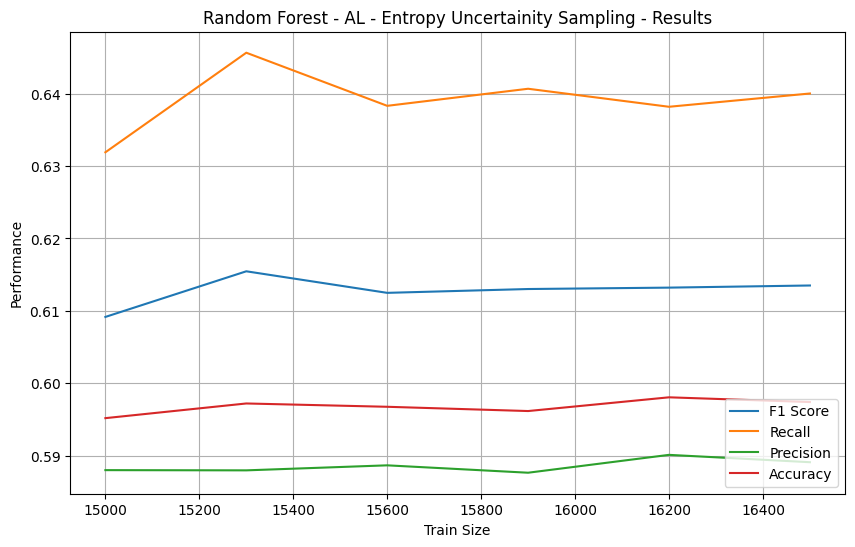

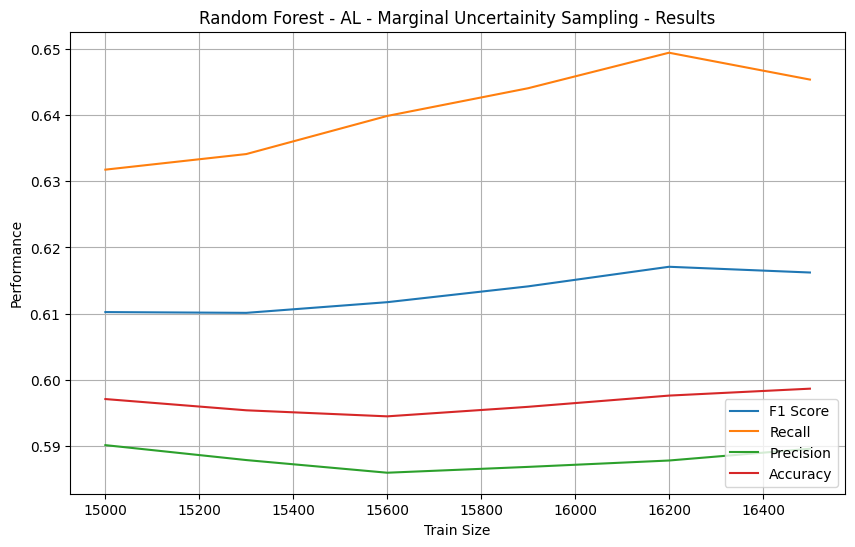

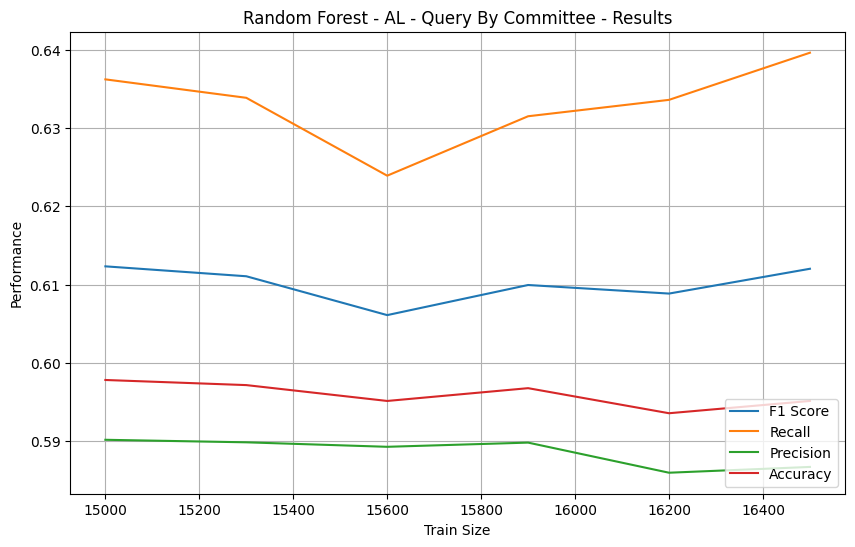

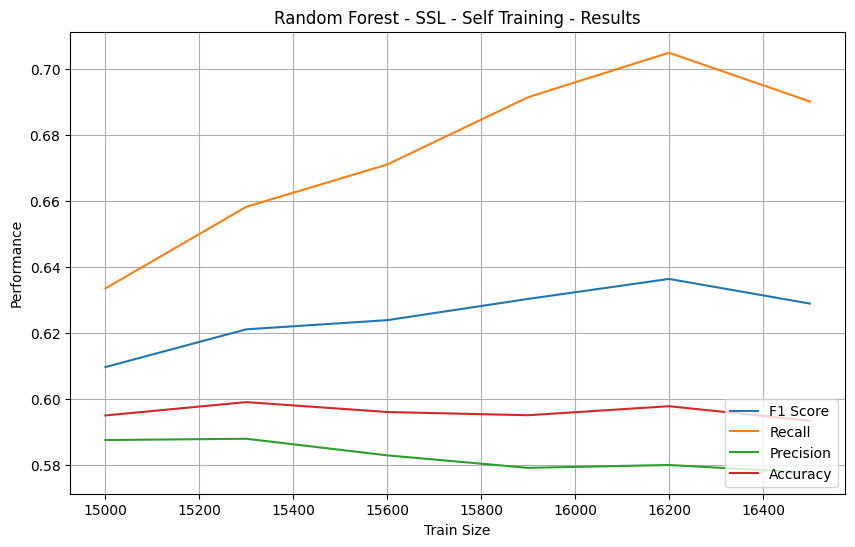

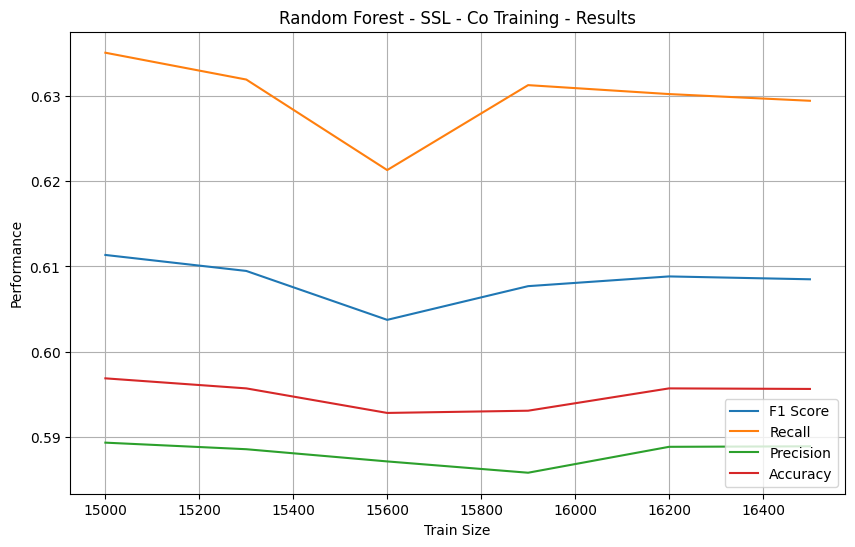

Accuracy of the trained  XGBoost   model before Fine tuning: 0.5817266845304229
F1_Score of the trained  XGBoost   model before Fine tuning: 0.5894277649473955
Precision of the trained  XGBoost   model before Fine tuning: 0.5779343313624355
Recall of the trained  XGBoost   model before Fine tuning: 0.6013876161801283
Best Parameters:  OrderedDict([('colsample_bytree', 0.8306230199583039), ('gamma', 1.4579325486042403), ('learning_rate', 0.030213000511300988), ('max_depth', 13), ('min_child_weight', 4), ('reg_alpha', 10.0), ('reg_lambda', 9.220109781974154), ('subsample', 1.0)])
Best Score:  0.6072666666666666
Accuracy of the trained  XGBoost  model after Fine tuning: 0.5981961963270375
F1_Score of the trained  XGBoost  model after Fine tuning: 0.6089058524173029
Precision of the trained  XGBoost   model after Fine tuning: 0.592253433980943
Recall of the trained  XGBoost   model after Fine tuning: 0.626521796046603


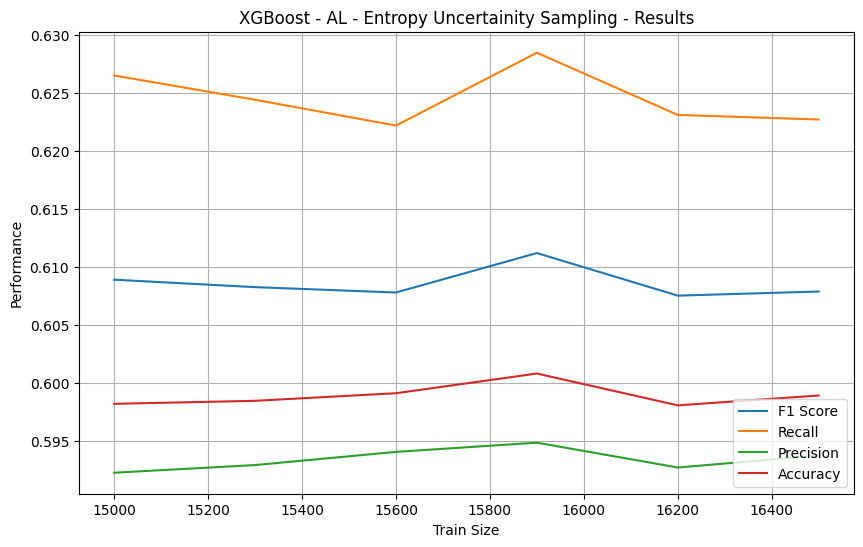

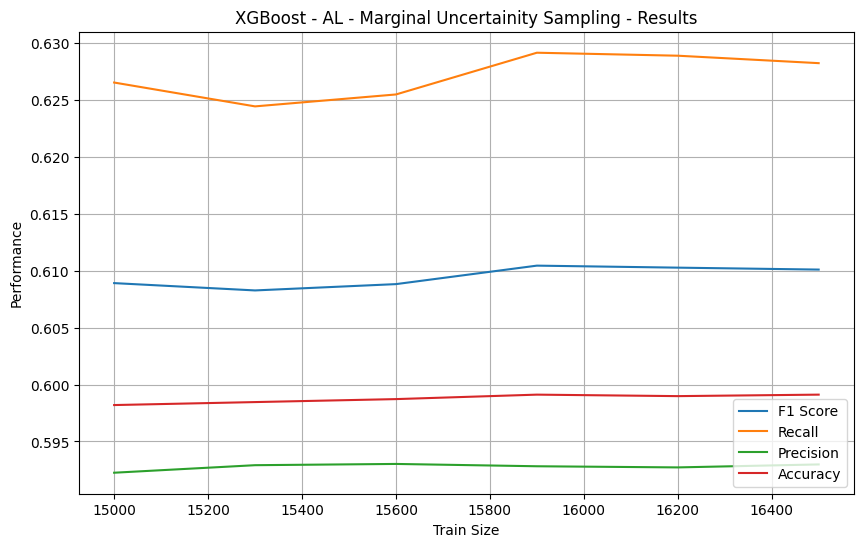

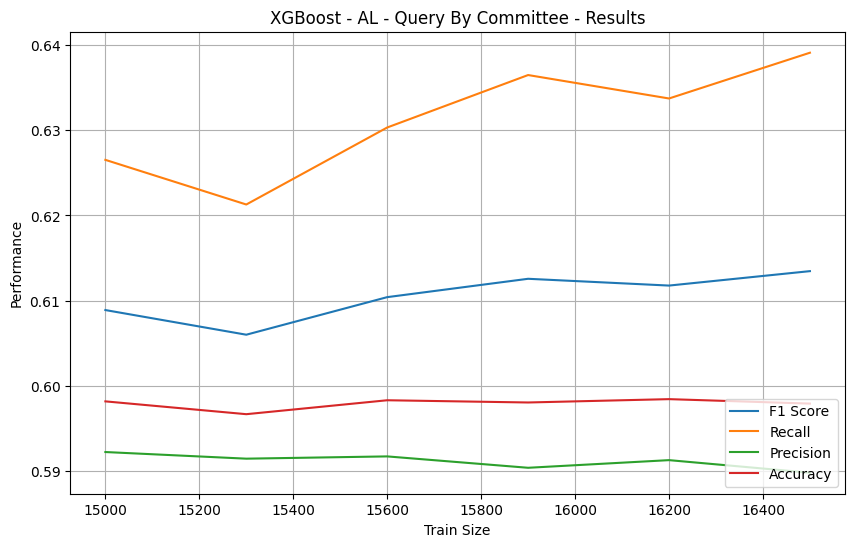

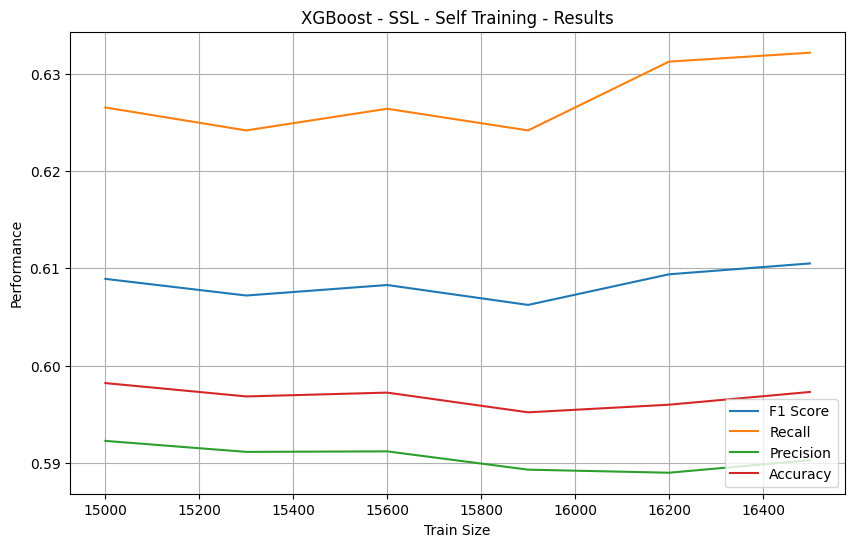

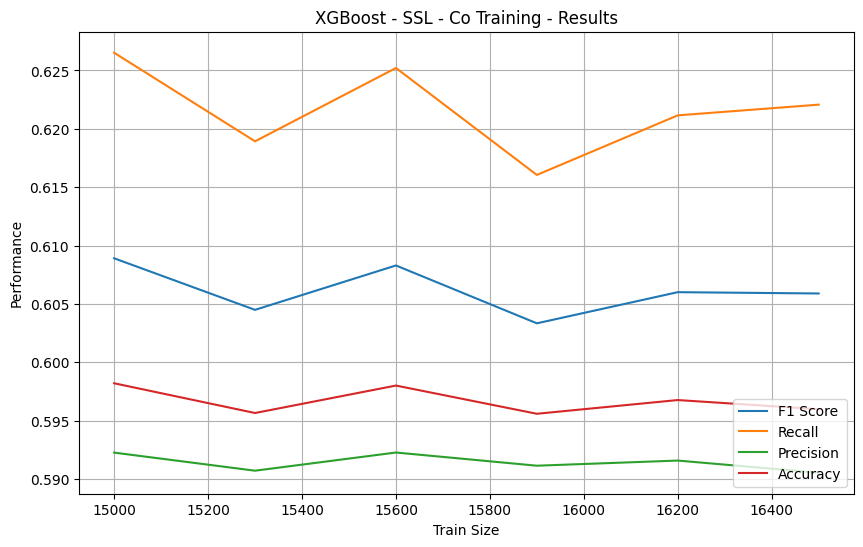

------------- 10*150 -------------
Accuracy of the trained  Random Forest   model before Fine tuning: 0.5891771779622247
F1_Score of the trained  Random Forest   model before Fine tuning: 0.5843142441475995
Precision of the trained  Random Forest   model before Fine tuning: 0.5904049178137111
Recall of the trained  Random Forest   model before Fine tuning: 0.5783479513025265
Best Parameters:  OrderedDict([('max_depth', 14), ('max_features', 'sqrt'), ('min_samples_leaf', 20), ('min_samples_split', 16), ('n_estimators', 99)])
Best Score:  0.6074666666666666
Accuracy of the trained  Random Forest  model after Fine tuning: 0.5987190379713744
F1_Score of the trained  Random Forest  model after Fine tuning: 0.6108998732572878
Precision of the trained  Random Forest   model after Fine tuning: 0.5920648568971871
Recall of the trained  Random Forest   model after Fine tuning: 0.6309726403979579


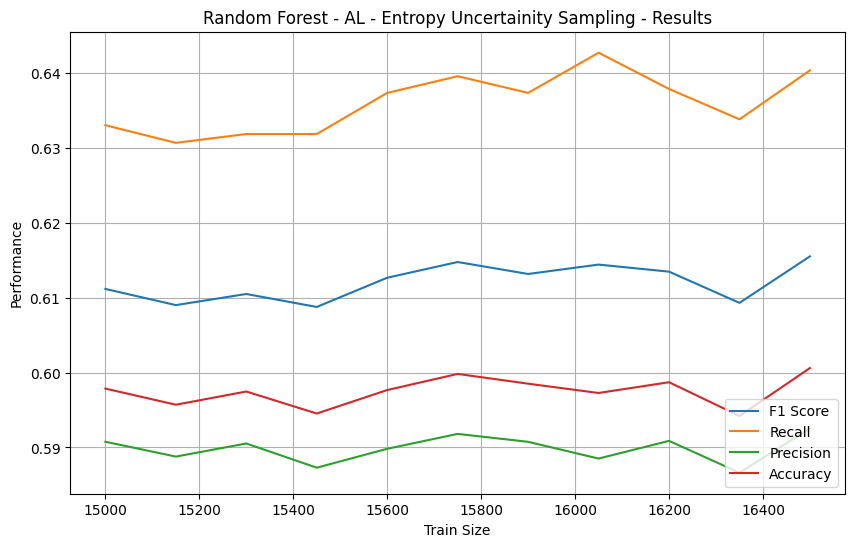

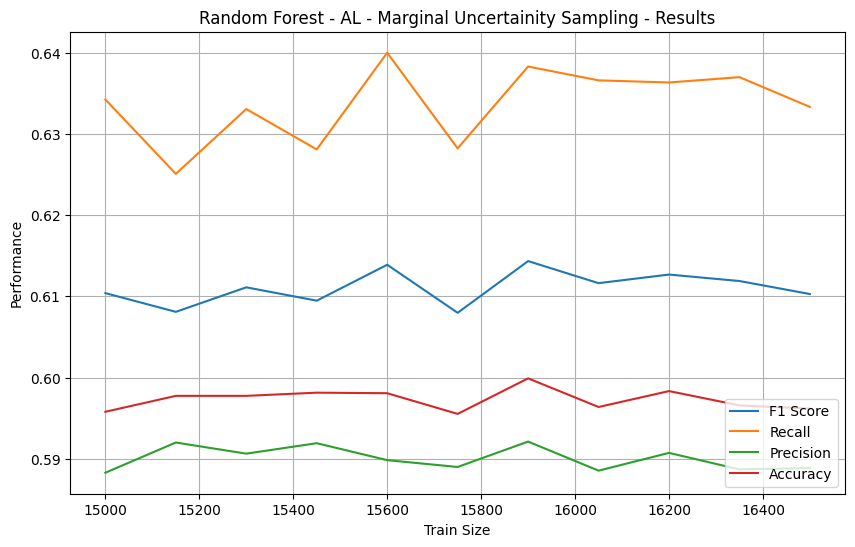

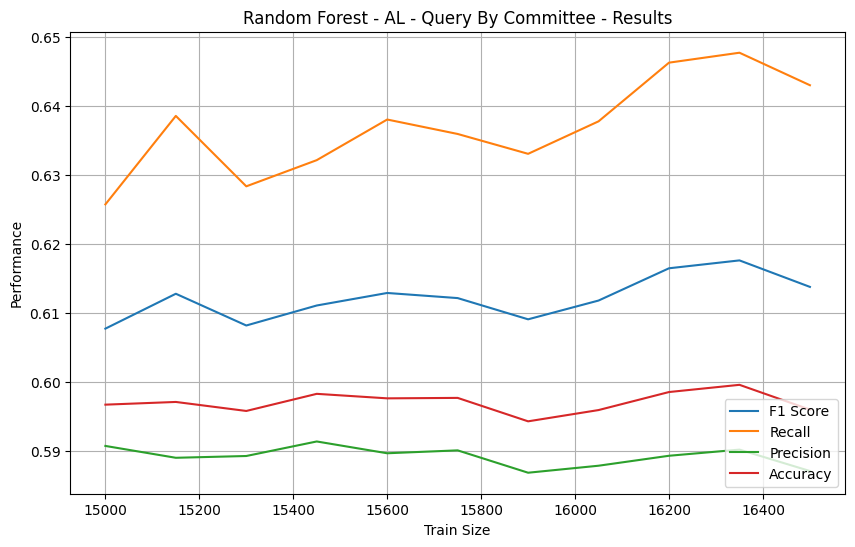

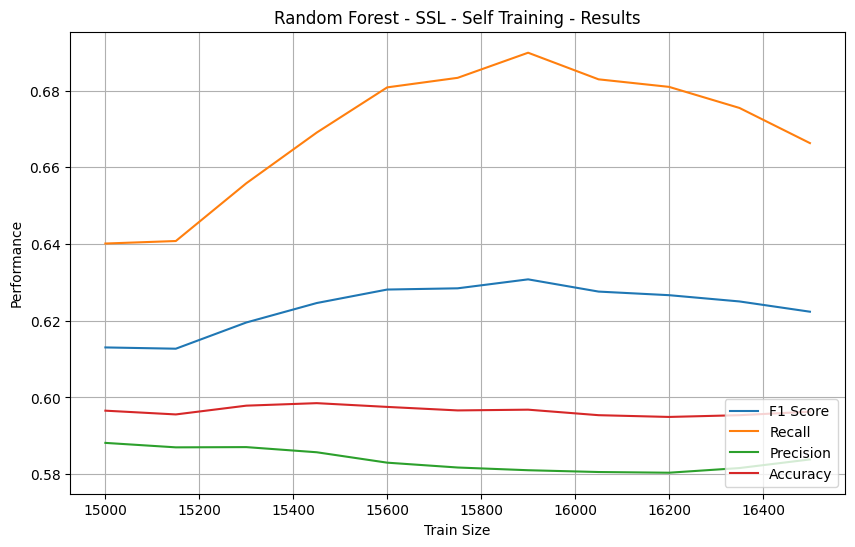

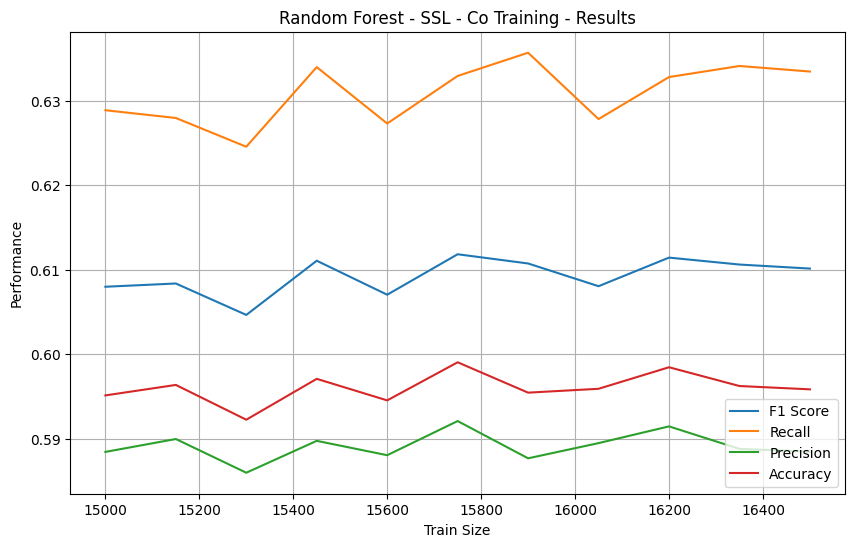

Accuracy of the trained  XGBoost   model before Fine tuning: 0.5817266845304229
F1_Score of the trained  XGBoost   model before Fine tuning: 0.5894277649473955
Precision of the trained  XGBoost   model before Fine tuning: 0.5779343313624355
Recall of the trained  XGBoost   model before Fine tuning: 0.6013876161801283
Best Parameters:  OrderedDict([('colsample_bytree', 0.8306230199583039), ('gamma', 1.4579325486042403), ('learning_rate', 0.030213000511300988), ('max_depth', 13), ('min_child_weight', 4), ('reg_alpha', 10.0), ('reg_lambda', 9.220109781974154), ('subsample', 1.0)])
Best Score:  0.6072666666666666
Accuracy of the trained  XGBoost  model after Fine tuning: 0.5981961963270375
F1_Score of the trained  XGBoost  model after Fine tuning: 0.6089058524173029
Precision of the trained  XGBoost   model after Fine tuning: 0.592253433980943
Recall of the trained  XGBoost   model after Fine tuning: 0.626521796046603


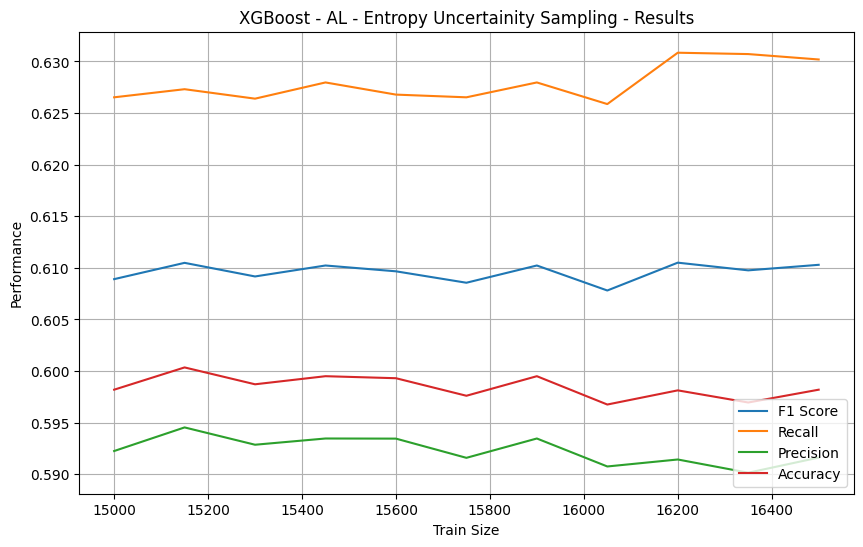

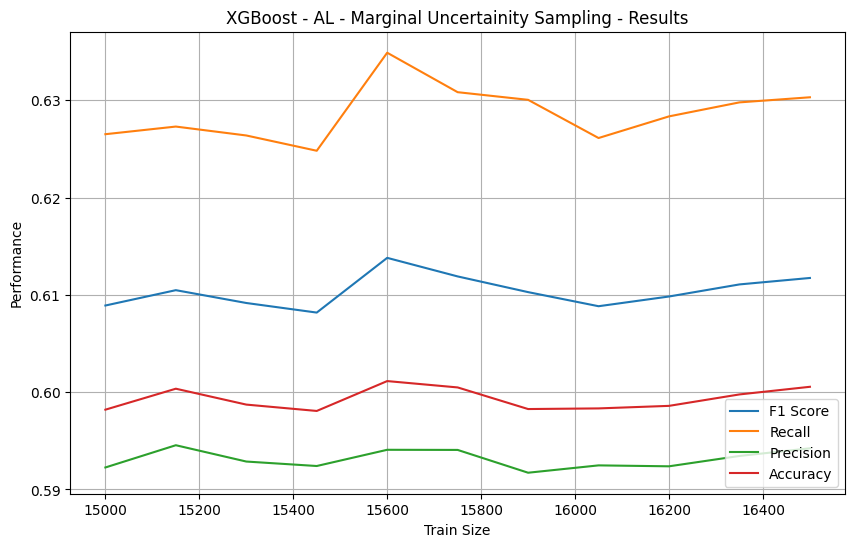

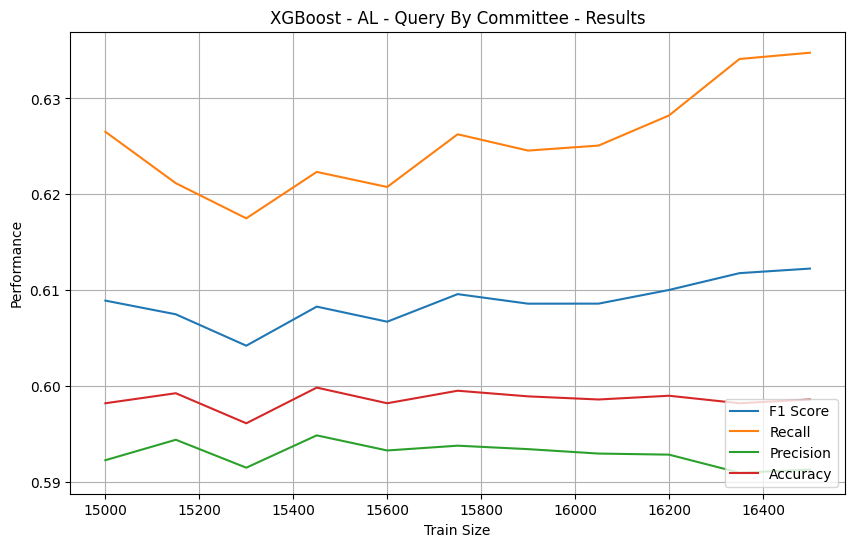

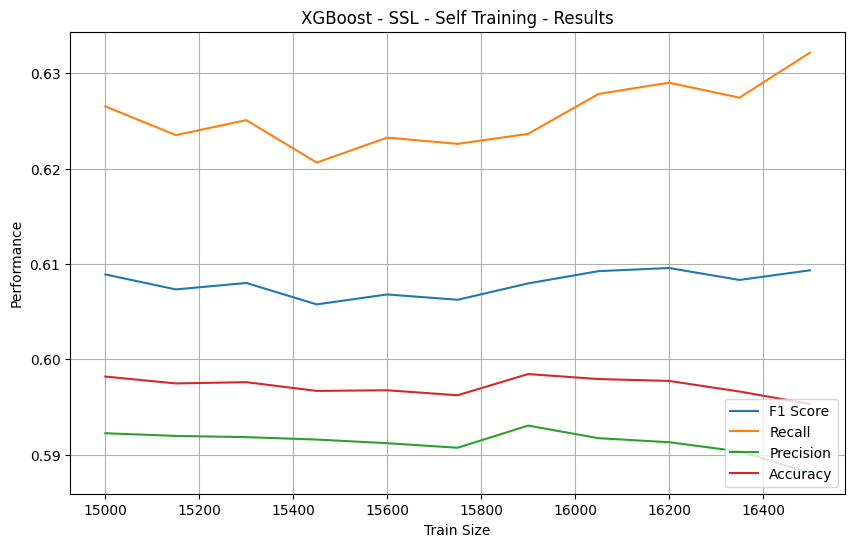

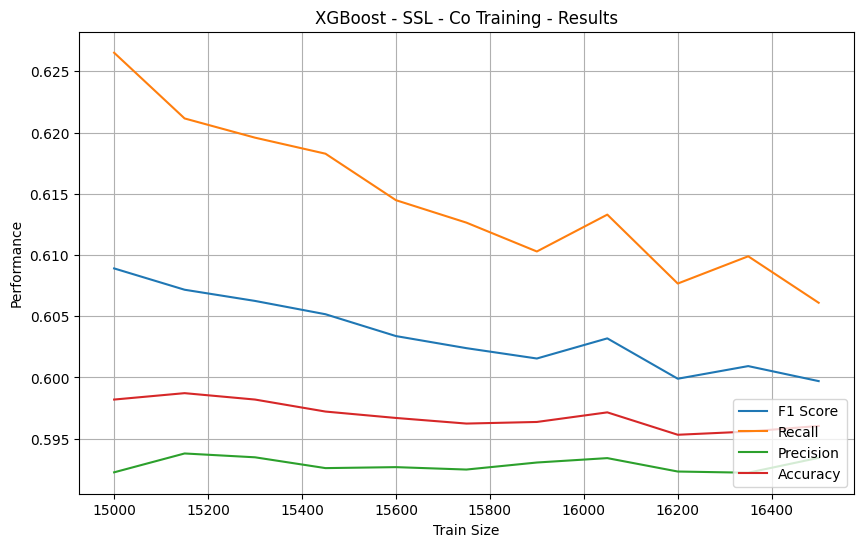

------------- 15*100 -------------
Accuracy of the trained  Random Forest   model before Fine tuning: 0.5906803476896935
F1_Score of the trained  Random Forest   model before Fine tuning: 0.5866279453501418
Precision of the trained  Random Forest   model before Fine tuning: 0.5915867944621939
Recall of the trained  Random Forest   model before Fine tuning: 0.5817515381594449
Best Parameters:  OrderedDict([('max_depth', 12), ('max_features', 'log2'), ('min_samples_leaf', 20), ('min_samples_split', 20), ('n_estimators', 100)])
Best Score:  0.608
Accuracy of the trained  Random Forest  model after Fine tuning: 0.5964969609829422
F1_Score of the trained  Random Forest  model after Fine tuning: 0.6124780316344464
Precision of the trained  Random Forest   model after Fine tuning: 0.588327505124804
Recall of the trained  Random Forest   model after Fine tuning: 0.6386961644194267


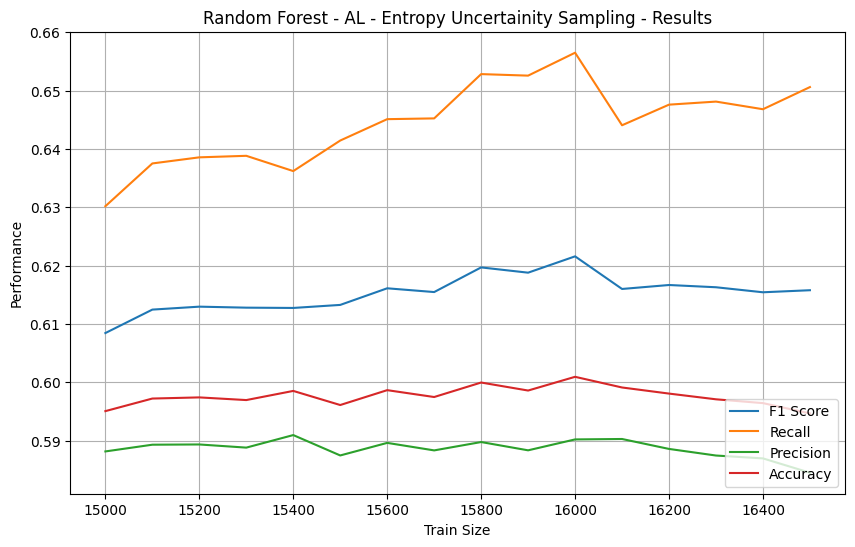

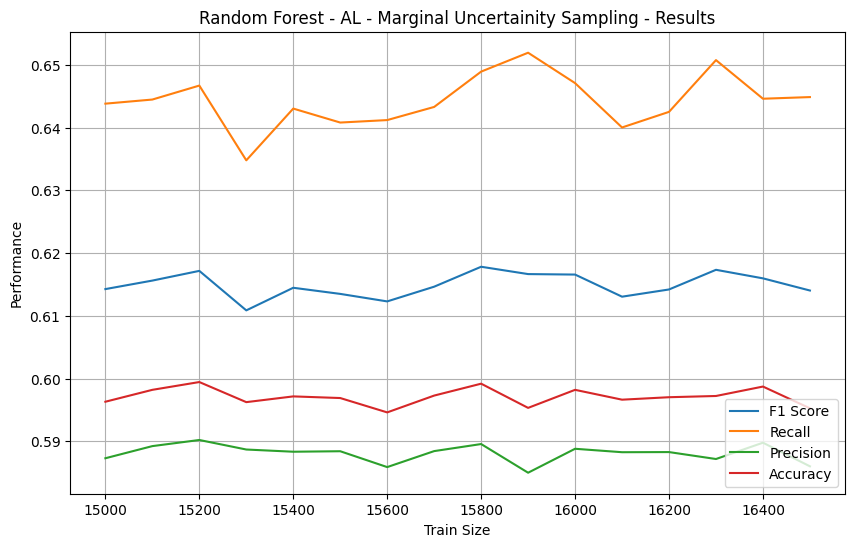

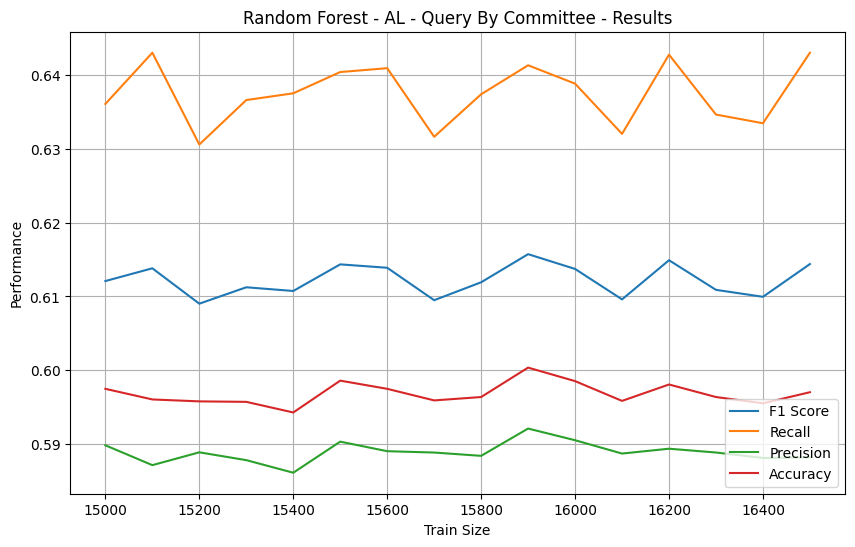

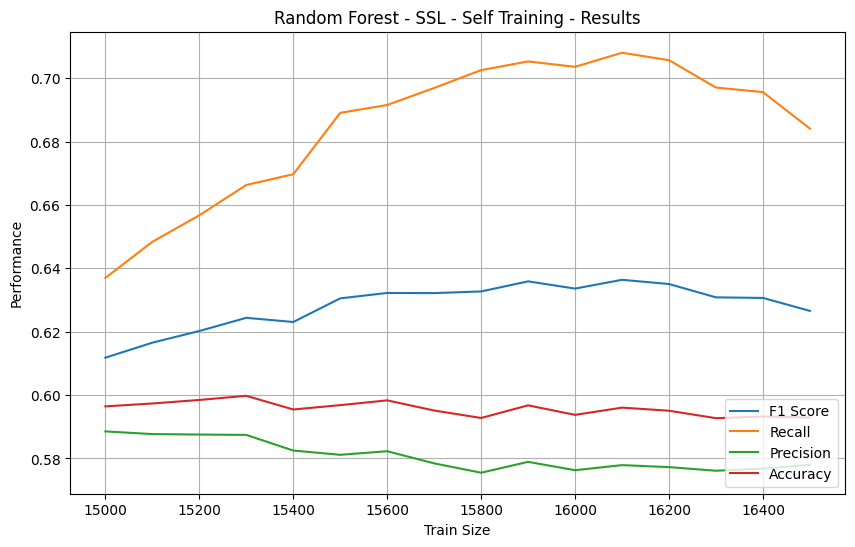

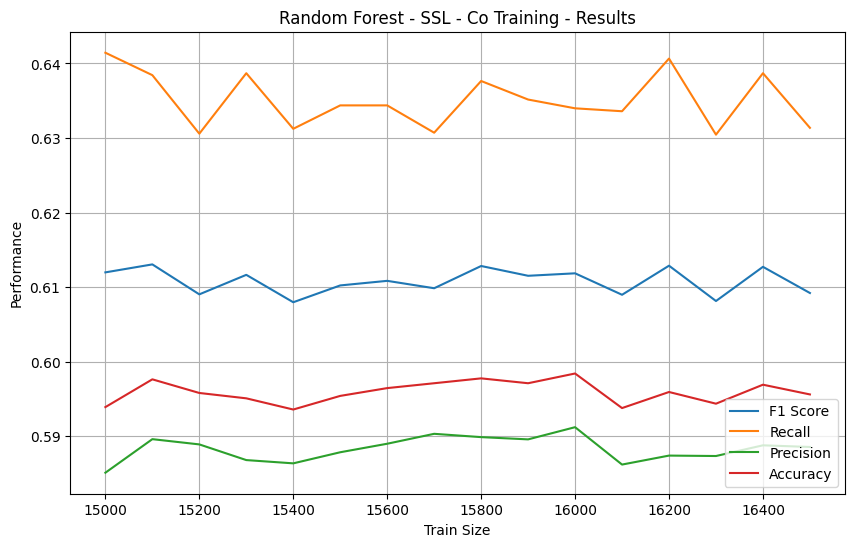

Accuracy of the trained  XGBoost   model before Fine tuning: 0.5817266845304229
F1_Score of the trained  XGBoost   model before Fine tuning: 0.5894277649473955
Precision of the trained  XGBoost   model before Fine tuning: 0.5779343313624355
Recall of the trained  XGBoost   model before Fine tuning: 0.6013876161801283
Best Parameters:  OrderedDict([('colsample_bytree', 0.8306230199583039), ('gamma', 1.4579325486042403), ('learning_rate', 0.030213000511300988), ('max_depth', 13), ('min_child_weight', 4), ('reg_alpha', 10.0), ('reg_lambda', 9.220109781974154), ('subsample', 1.0)])
Best Score:  0.6072666666666666
Accuracy of the trained  XGBoost  model after Fine tuning: 0.5981961963270375
F1_Score of the trained  XGBoost  model after Fine tuning: 0.6089058524173029
Precision of the trained  XGBoost   model after Fine tuning: 0.592253433980943
Recall of the trained  XGBoost   model after Fine tuning: 0.626521796046603


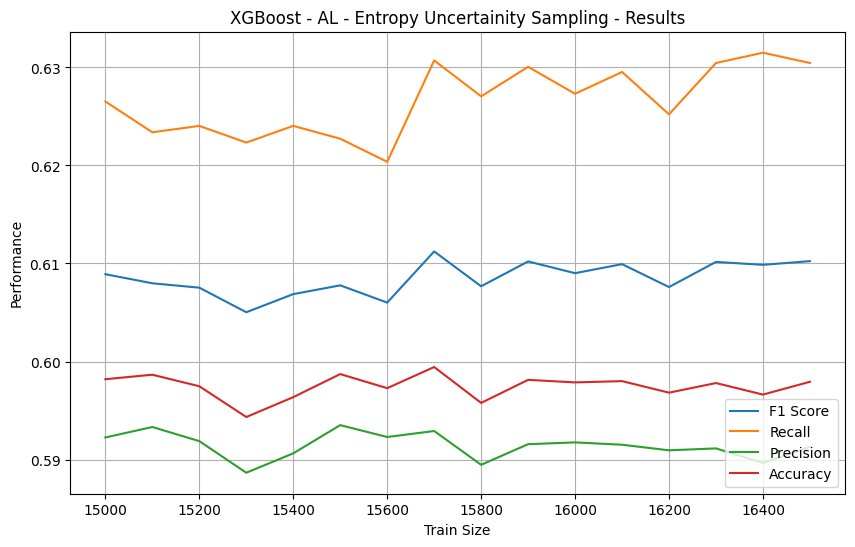

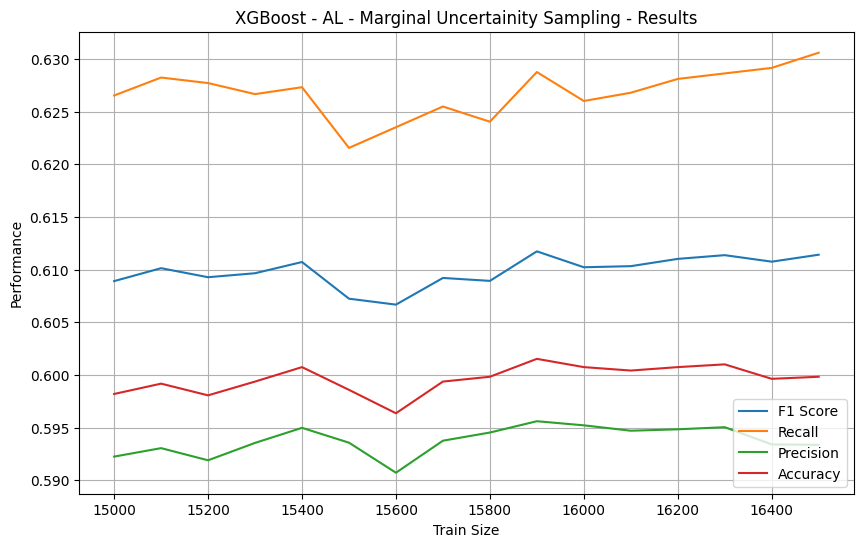

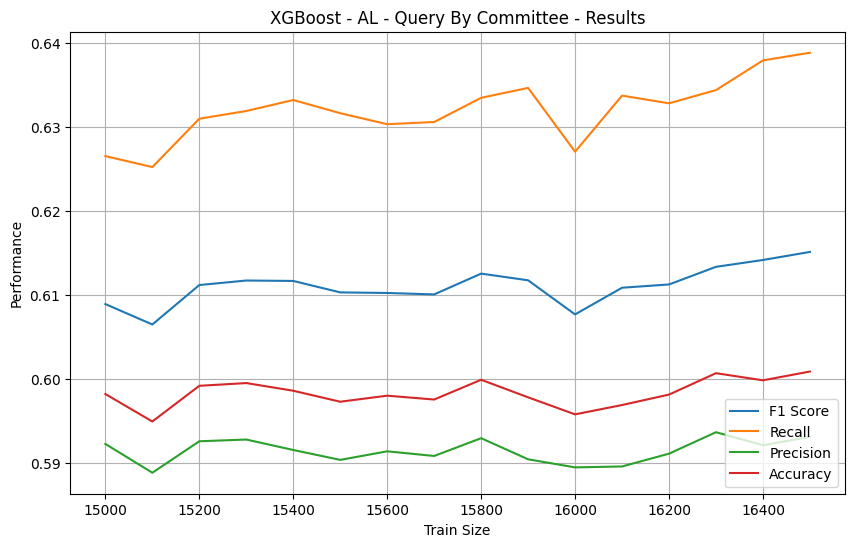

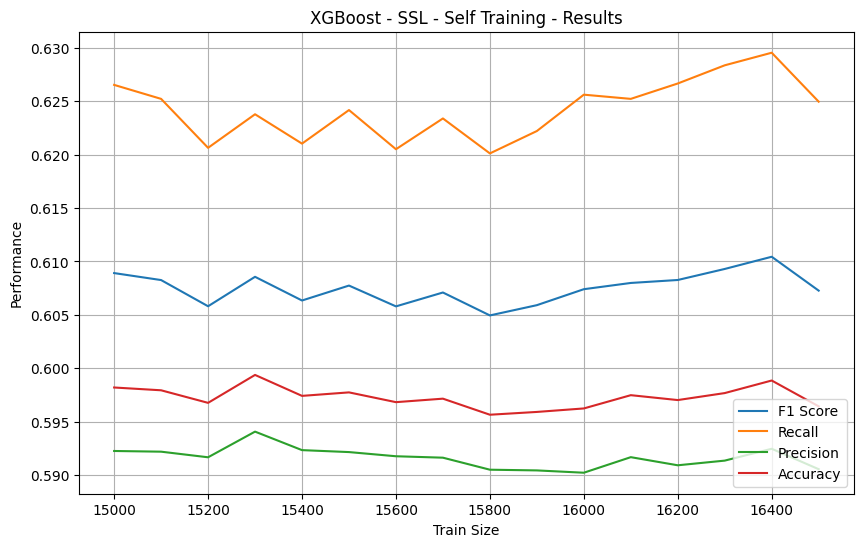

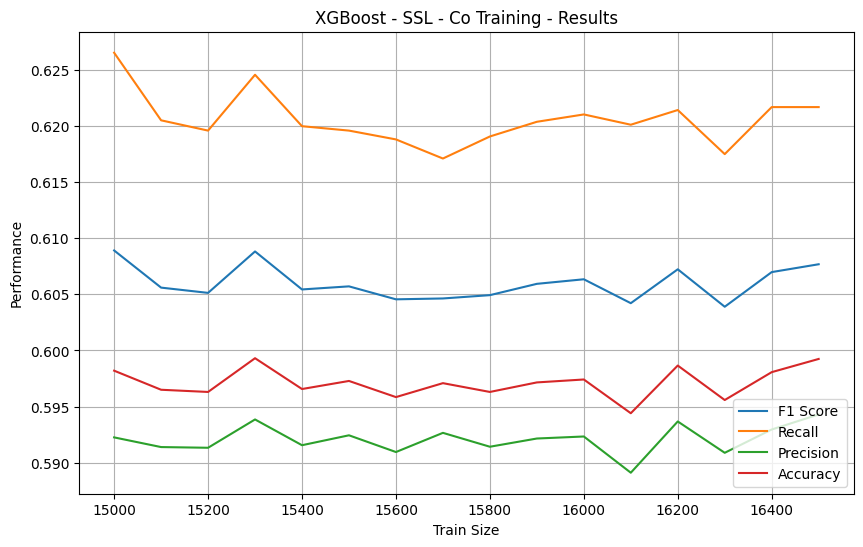

------------- 20*75 -------------
Accuracy of the trained  Random Forest   model before Fine tuning: 0.5853865760407817
F1_Score of the trained  Random Forest   model before Fine tuning: 0.5812541254125413
Precision of the trained  Random Forest   model before Fine tuning: 0.5862068965517241
Recall of the trained  Random Forest   model before Fine tuning: 0.5763843435004582
Best Parameters:  OrderedDict([('max_depth', 20), ('max_features', 'log2'), ('min_samples_leaf', 9), ('min_samples_split', 10), ('n_estimators', 62)])
Best Score:  0.6067333333333333
Accuracy of the trained  Random Forest  model after Fine tuning: 0.5978040650937847
F1_Score of the trained  Random Forest  model after Fine tuning: 0.6062699936020474
Precision of the trained  Random Forest   model after Fine tuning: 0.5929170316606182
Recall of the trained  Random Forest   model after Fine tuning: 0.6202382510799843


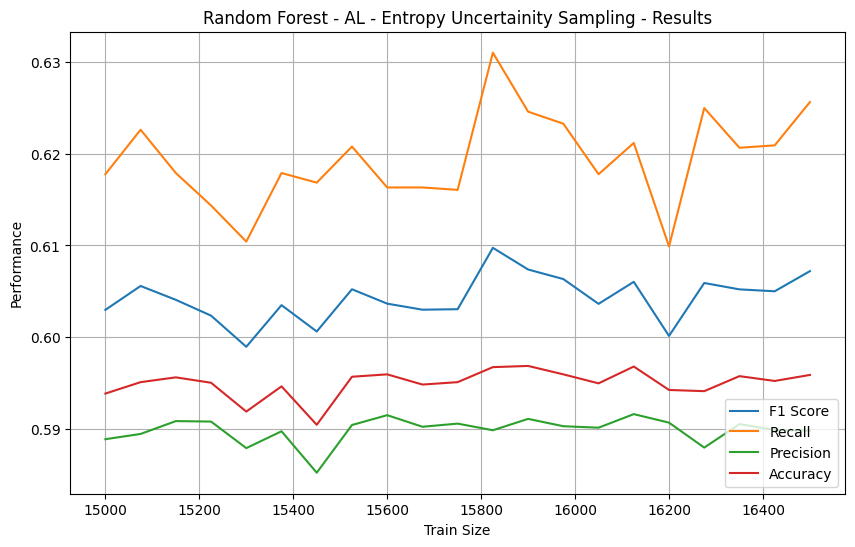

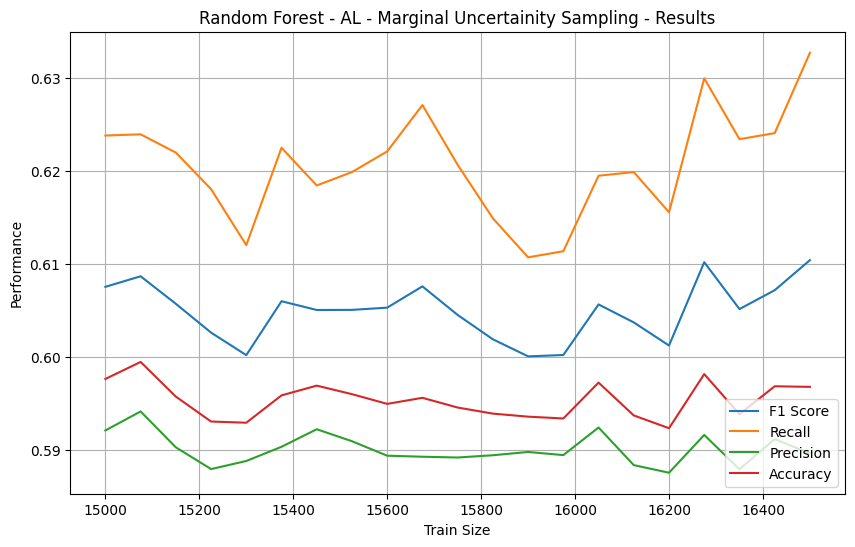

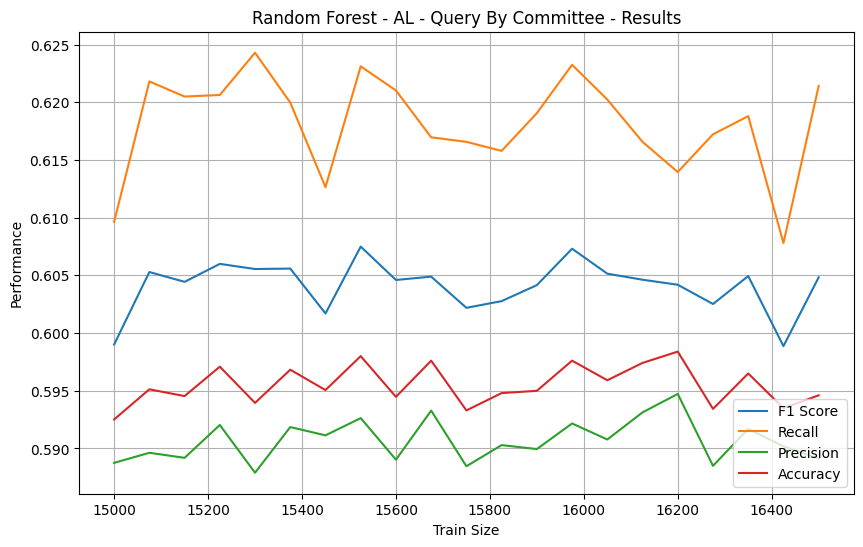

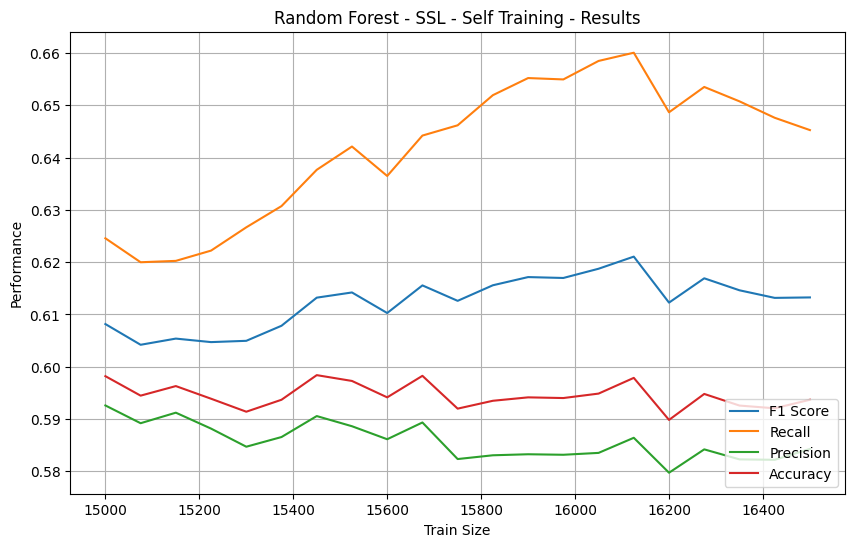

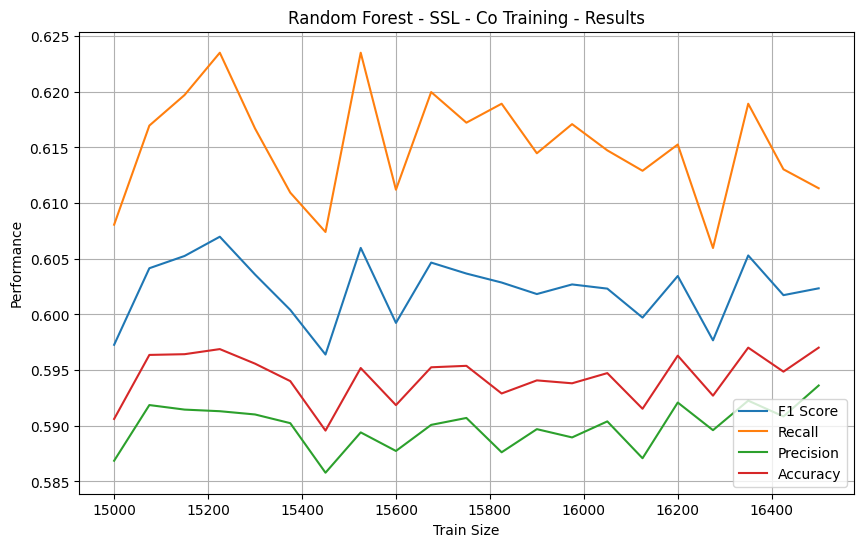

Accuracy of the trained  XGBoost   model before Fine tuning: 0.5817266845304229
F1_Score of the trained  XGBoost   model before Fine tuning: 0.5894277649473955
Precision of the trained  XGBoost   model before Fine tuning: 0.5779343313624355
Recall of the trained  XGBoost   model before Fine tuning: 0.6013876161801283
Best Parameters:  OrderedDict([('colsample_bytree', 0.8306230199583039), ('gamma', 1.4579325486042403), ('learning_rate', 0.030213000511300988), ('max_depth', 13), ('min_child_weight', 4), ('reg_alpha', 10.0), ('reg_lambda', 9.220109781974154), ('subsample', 1.0)])
Best Score:  0.6072666666666666
Accuracy of the trained  XGBoost  model after Fine tuning: 0.5981961963270375
F1_Score of the trained  XGBoost  model after Fine tuning: 0.6089058524173029
Precision of the trained  XGBoost   model after Fine tuning: 0.592253433980943
Recall of the trained  XGBoost   model after Fine tuning: 0.626521796046603


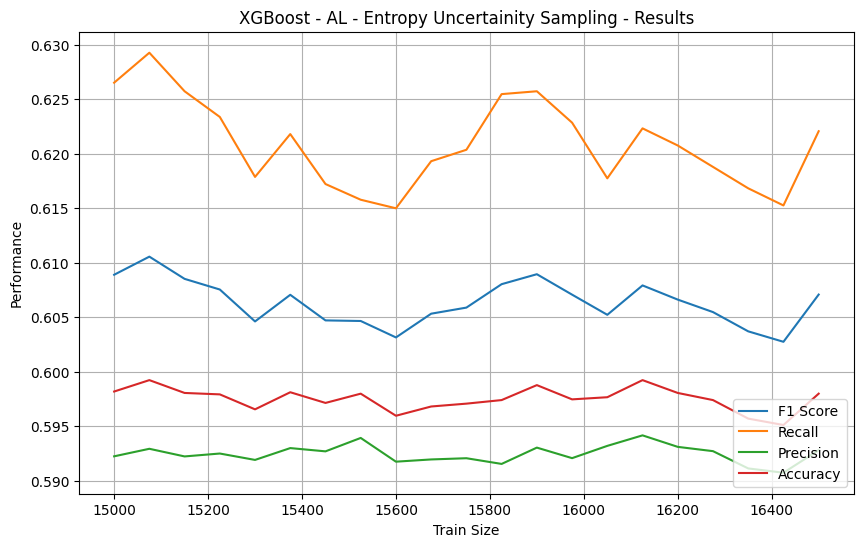

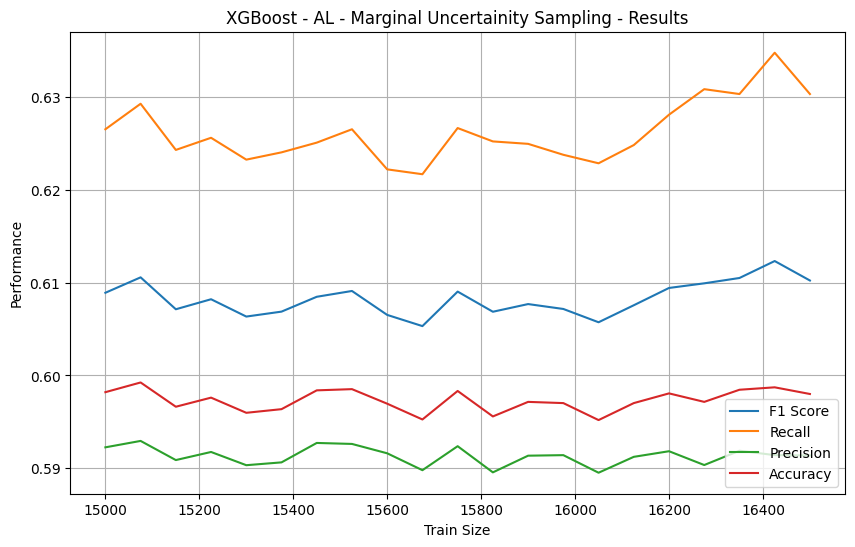

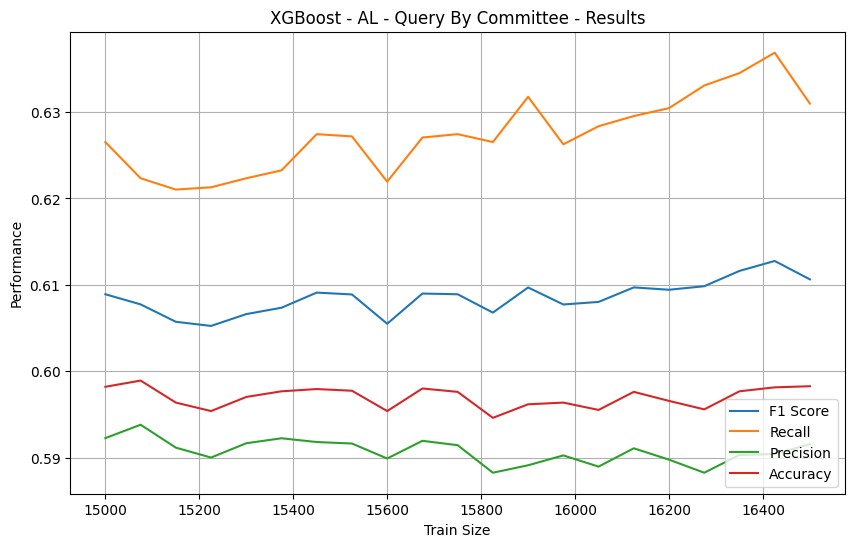

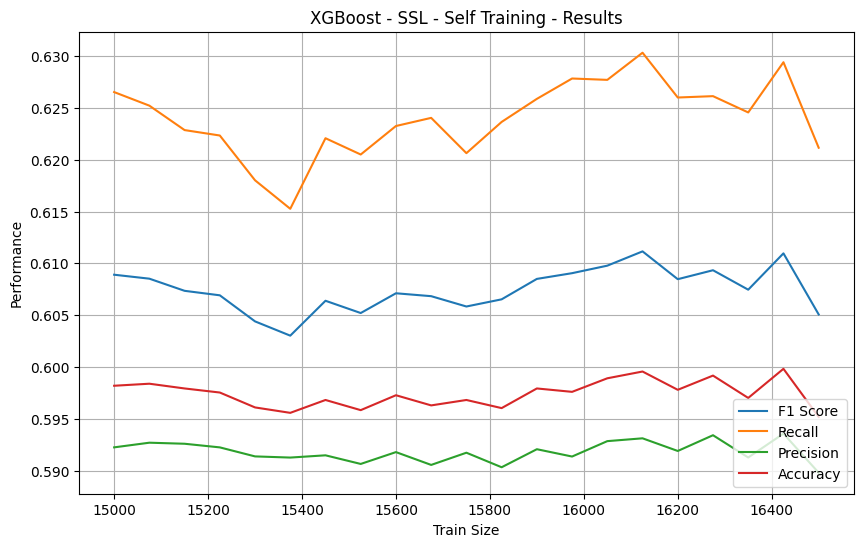

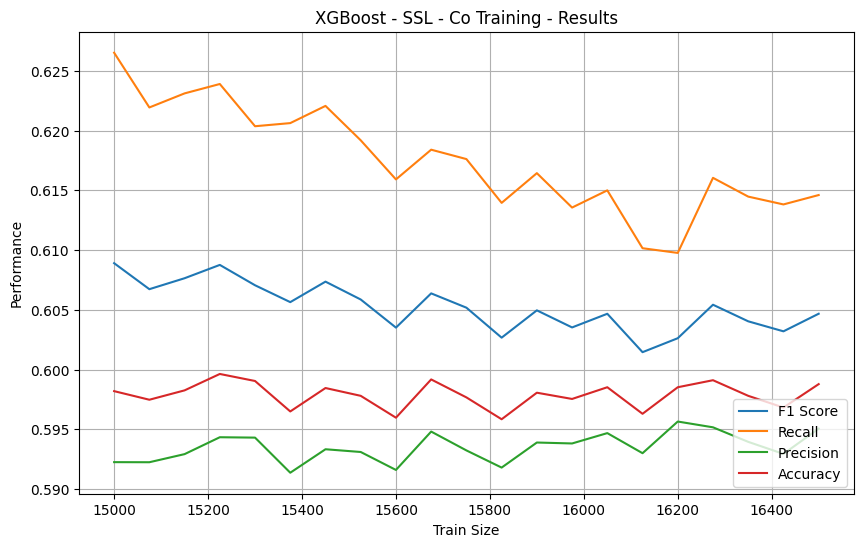

------------- 25*60 -------------
Accuracy of the trained  Random Forest   model before Fine tuning: 0.593686687144631
F1_Score of the trained  Random Forest   model before Fine tuning: 0.5888499437867867
Precision of the trained  Random Forest   model before Fine tuning: 0.595028067361668
Recall of the trained  Random Forest   model before Fine tuning: 0.5827987956538814
Best Parameters:  OrderedDict([('max_depth', 13), ('max_features', 'sqrt'), ('min_samples_leaf', 8), ('min_samples_split', 18), ('n_estimators', 63)])
Best Score:  0.6083333333333334
Accuracy of the trained  Random Forest  model after Fine tuning: 0.5996993660545062
F1_Score of the trained  Random Forest  model after Fine tuning: 0.6167323696890057
Precision of the trained  Random Forest   model after Fine tuning: 0.5907456245504675
Recall of the trained  Random Forest   model after Fine tuning: 0.6451106165728498


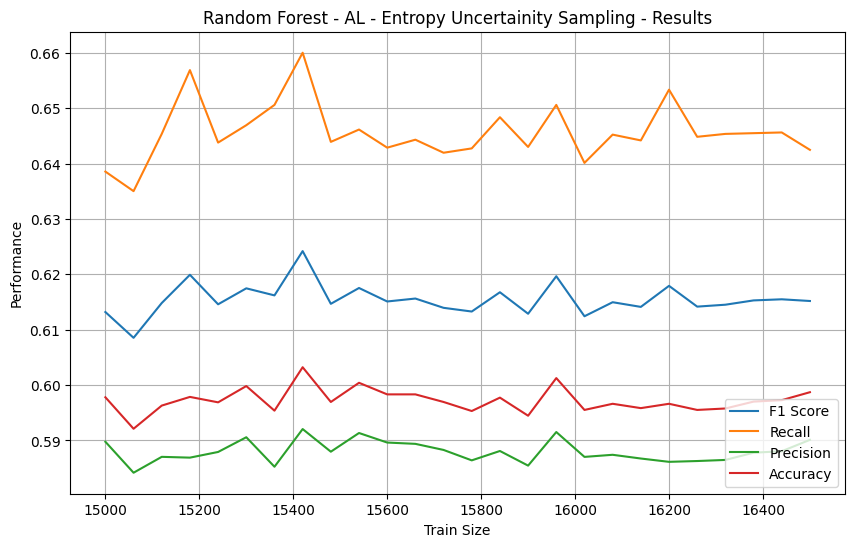

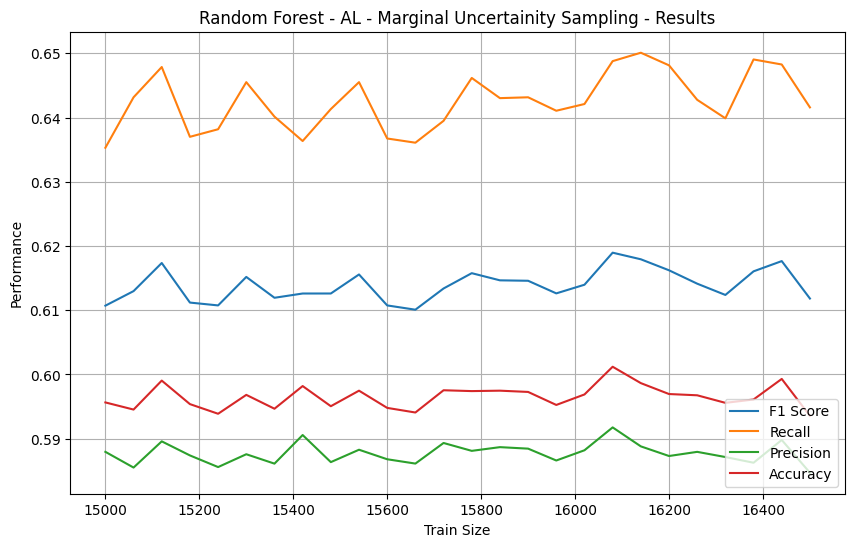

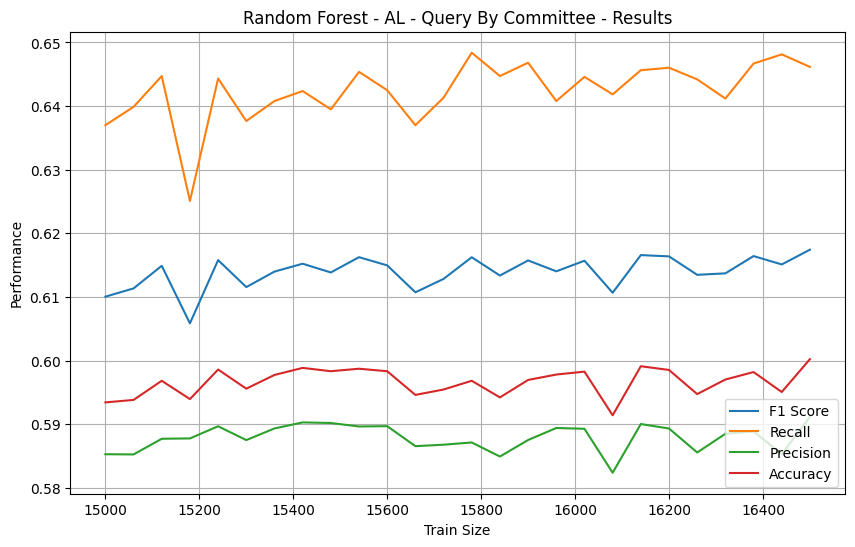

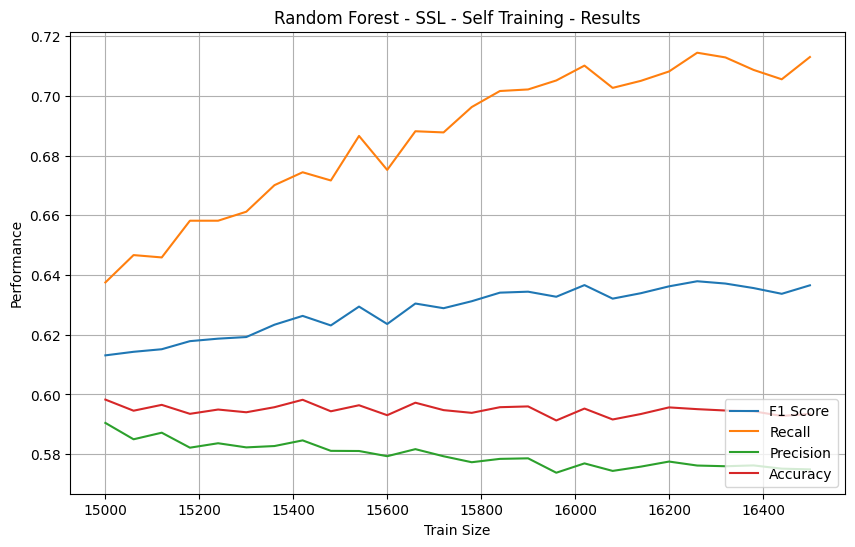

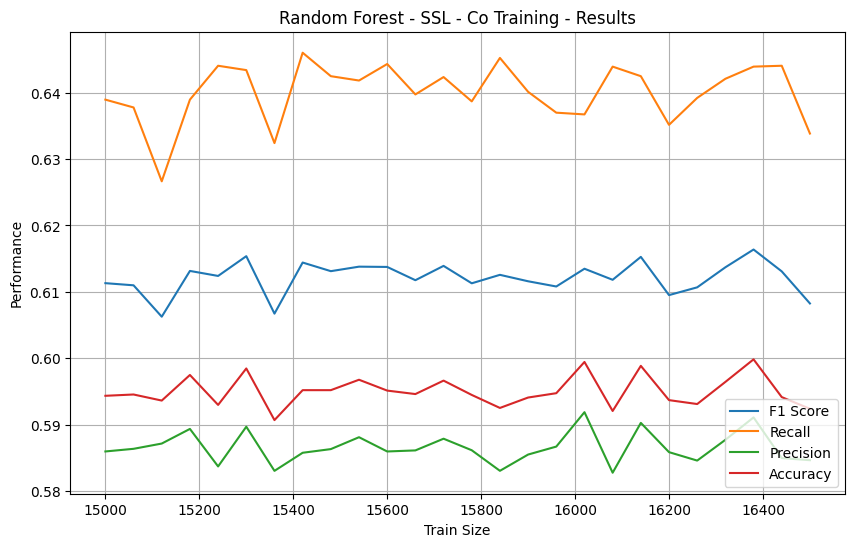

Accuracy of the trained  XGBoost   model before Fine tuning: 0.5817266845304229
F1_Score of the trained  XGBoost   model before Fine tuning: 0.5894277649473955
Precision of the trained  XGBoost   model before Fine tuning: 0.5779343313624355
Recall of the trained  XGBoost   model before Fine tuning: 0.6013876161801283
Best Parameters:  OrderedDict([('colsample_bytree', 0.8306230199583039), ('gamma', 1.4579325486042403), ('learning_rate', 0.030213000511300988), ('max_depth', 13), ('min_child_weight', 4), ('reg_alpha', 10.0), ('reg_lambda', 9.220109781974154), ('subsample', 1.0)])
Best Score:  0.6072666666666666
Accuracy of the trained  XGBoost  model after Fine tuning: 0.5981961963270375
F1_Score of the trained  XGBoost  model after Fine tuning: 0.6089058524173029
Precision of the trained  XGBoost   model after Fine tuning: 0.592253433980943
Recall of the trained  XGBoost   model after Fine tuning: 0.626521796046603


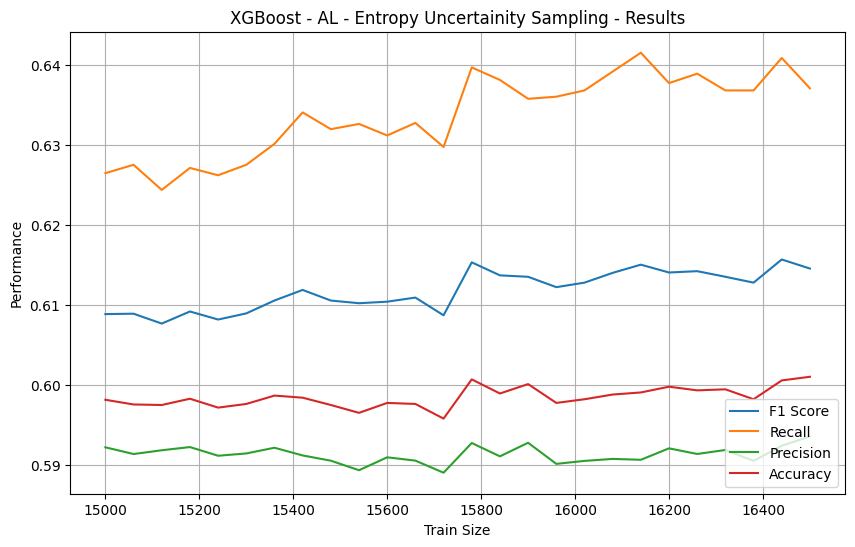

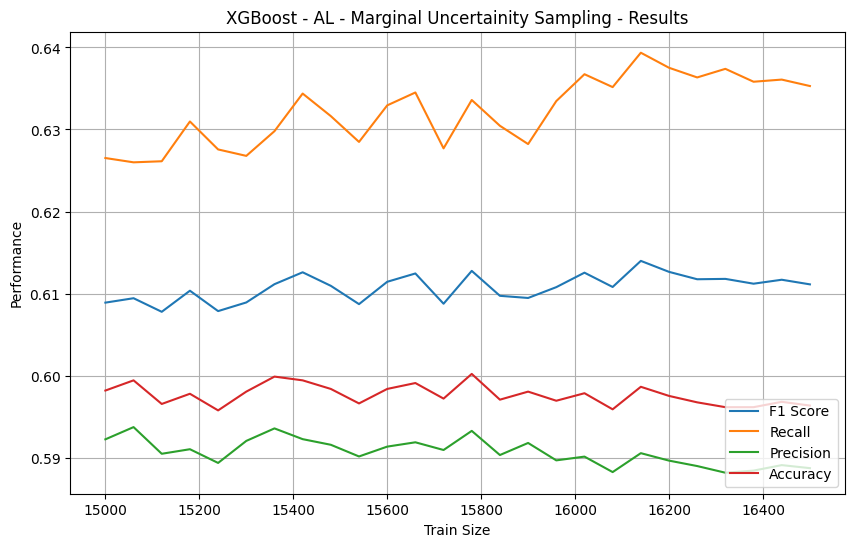

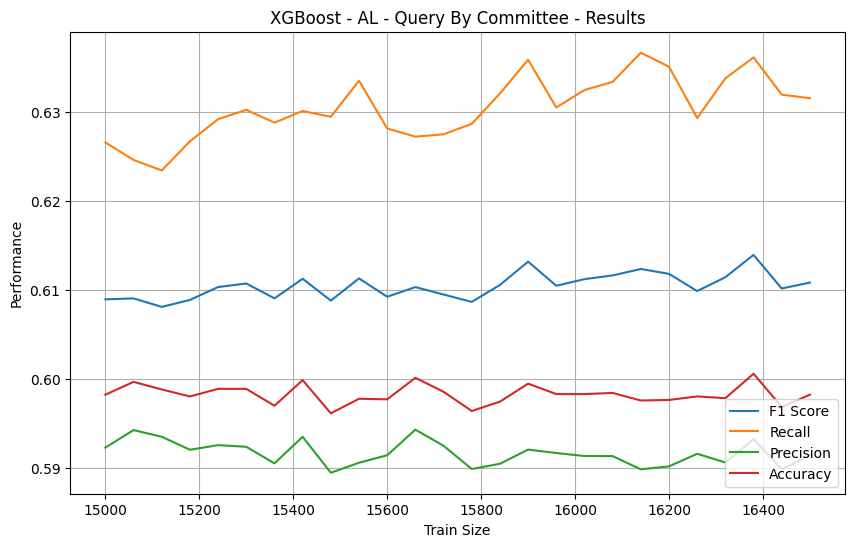

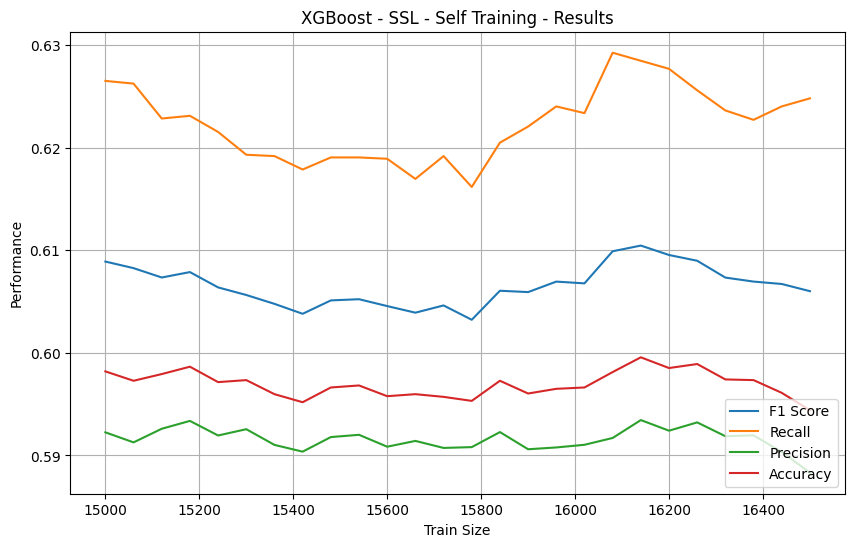

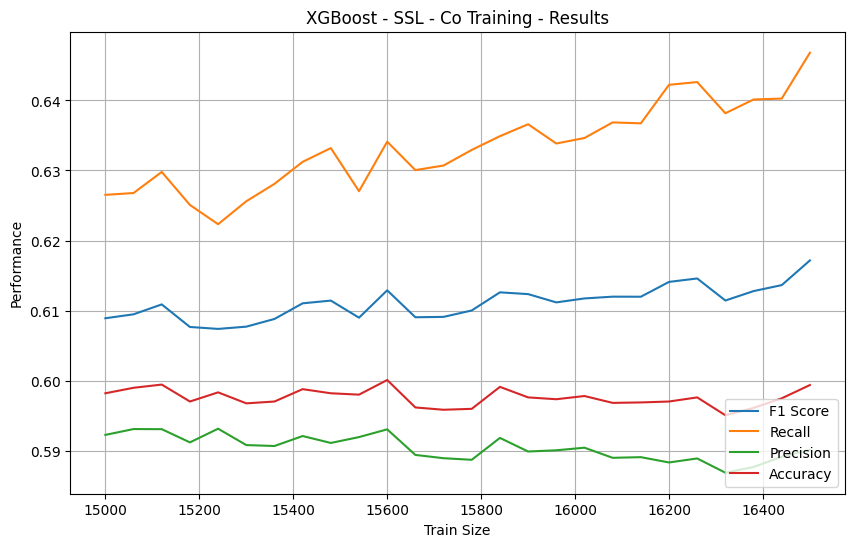

In [ ]:

weight_class_0 = y_train.value_counts()[0]
weight_class_1 = y_train.value_counts()[1]
ratio = weight_class_0/weight_class_1

models = {
    'Random Forest': RandomForestClassifier(class_weight="balanced"),
    'XGBoost': XGBClassifier(scale_pos_weight=ratio)
}


param_dist_rf = {
        'n_estimators': Integer(10, 100),
        'max_depth': Integer(1, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2'])
    }

param_dist_xgb = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'max_depth': Integer(1, 20),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'gamma': Real(0, 5.0, prior='uniform'),
    'reg_alpha': Real(0, 10.0, prior='uniform'),
    'reg_lambda': Real(0, 10.0, prior='uniform')
}

grids = {
    'Random Forest': param_dist_rf,
    'XGBoost': param_dist_xgb
}

itters = [5,10,15,20,25]


for itter in itters:
  nq = int(1500/itter)
  print("------------- "+str(itter) + "*" + str(nq)+ " -------------")
  run_algorithms(models, grids,_itterations=itter, _n_queries = nq)


# Plotting Performance Comparison

In [ ]:
import pandas as pd
def custom_table(styler):
    vmin = styler.data.values.min()
    vmax = styler.data.values.max()
    mid = (vmin + vmax) / 2
    styler = styler.background_gradient(cmap="RdYlBu", axis=None, vmin=vmin, vmax=vmax)

    styler = styler.applymap(lambda x: 'text-align: center; font-size: 14px;')
    return styler

methods = {"Entropy Uncertainity Sampling":" - AL - ",
           "Marginal Uncertainity Sampling":" - AL - ",
          "Query By Committee":" - AL - ",
           "Self Training":" - SSL - ",
           "Co Training":" - SSL - "}

directory = "Malware Prediction/result/"

model = "XGBoost"

results = []
itters = [5,10,15,20,25]


for itter in itters:
  n_queries = int(1500/itter)
  for method, name in methods.items():
      title = model + name + method +  " - Results"
      file_name = directory + title + "nq_" + str(n_queries) +"-iter_"+str(itter) + "-Results.csv"
      df = pd.read_csv(file_name)
      df = df.drop(columns=["Train Size","Pool size","Selected Indices"])
      last_row = df.iloc[-1, :].copy()
      last_row["Method"] = model + name + method
      last_row["N_queries"] = n_queries
      last_row["N_itters"] = itter
      results.append(last_row)


appended_df = pd.DataFrame(results)

columns_order = ['Method'] + list(df.columns) + ['N_itters', 'N_queries']
appended_df = appended_df[columns_order]

appended_df = appended_df.reset_index()

appended_df = appended_df.drop("index", axis = 1)
appended_df




Method  Accuracy  F1_Score  \
0    XGBoost - AL - Entropy Uncertainity Sampling  0.598915  0.607884   
1   XGBoost - AL - Marginal Uncertainity Sampling  0.599111  0.610094   
2               XGBoost - AL - Query By Committee  0.597935  0.613471   
3                   XGBoost - SSL - Self Training  0.597281  0.610493   
4                     XGBoost - SSL - Co Training  0.595974  0.605891   
5    XGBoost - AL - Entropy Uncertainity Sampling  0.598196  0.610294   
6   XGBoost - AL - Marginal Uncertainity Sampling  0.600549  0.611739   
7               XGBoost - AL - Query By Committee  0.598588  0.612247   
8                   XGBoost - SSL - Self Training  0.595321  0.609338   
9                     XGBoost - SSL - Co Training  0.596039  0.599702   
10   XGBoost - AL - Entropy Uncertainity Sampling  0.597935  0.610238   
11  XGBoost - AL - Marginal Uncertainity Sampling  0.599830  0.611411   
12              XGBoost - AL - Query By Committee  0.600876  0.615113   
13                  XGBoost - SSL - Self Training  0.596432  0.607263   
14                    XGBoost - SSL - Co Training  0.599242  0.607678   
15   XGBoost - AL - Entropy Uncertainity Sampling  0.598000  0.607090   
16  XGBoost - AL - Marginal Uncertainity Sampling  0.598000  0.610227   
17              XGBoost - AL - Query By Committee  0.598262  0.610629   
18                  XGBoost - SSL - Self Training  0.595190  0.605075   
19                    XGBoost - SSL - Co Training  0.598784  0.604675   
20   XGBoost - AL - Entropy Uncertainity Sampling  0.601072  0.614598   
21  XGBoost - AL - Marginal Uncertainity Sampling  0.596366  0.611132   
22              XGBoost - AL - Query By Committee  0.598196  0.610788   
23                  XGBoost - SSL - Self Training  0.594406  0.606018   
24                    XGBoost - SSL - Co Training  0.599373  0.617162   

    Precision    Recall  N_itters  N_queries  
0    0.593734  0.622725         5        300  
1    0.592982  0.628224         5        300  
2    0.589827  0.639089         5        300  
3    0.590270  0.632151         5        300  
4    0.590531  0.622071         5        300  
5    0.591619  0.630187        10        150  
6    0.594224  0.630318        10        150  
7    0.591269  0.634769        10        150  
8    0.588114  0.632151        10        150  
9    0.593438  0.606100        10        150  
10   0.591283  0.630449        15        100  
11   0.593373  0.630580        15        100  
12   0.593097  0.638827        15        100  
13   0.590549  0.624951        15        100  
14   0.594294  0.621678        15        100  
15   0.592814  0.622071        20         75  
16   0.591378  0.630318        20         75  
17   0.591556  0.630973        20         75  
18   0.589807  0.621155        20         75  
19   0.595057  0.614609        20         75  
20   0.593609  0.637125        25         60  
21   0.588742  0.635293        25         60  
22   0.591394  0.631496        25         60  
23   0.588315  0.624820        25         60  
24   0.590111  0.646812        25         60

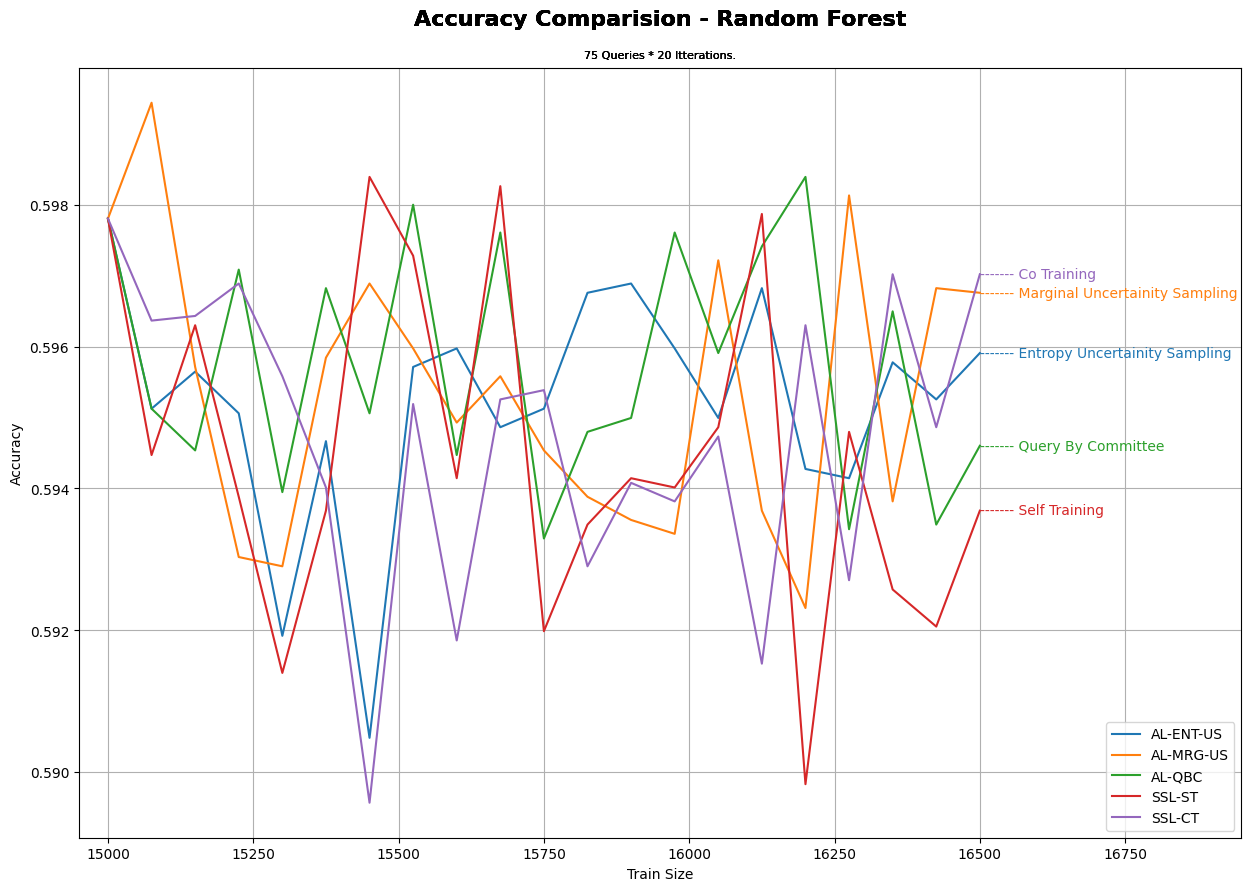

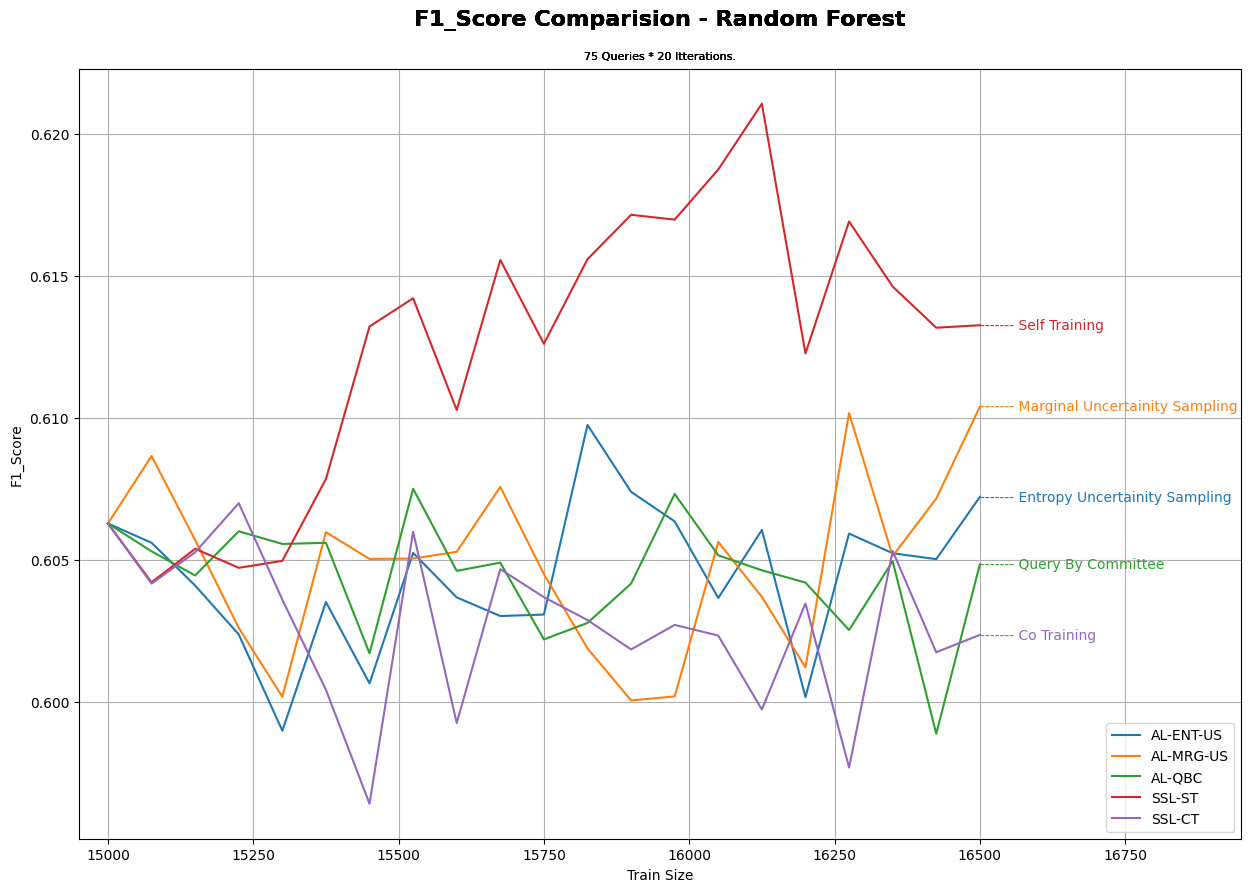

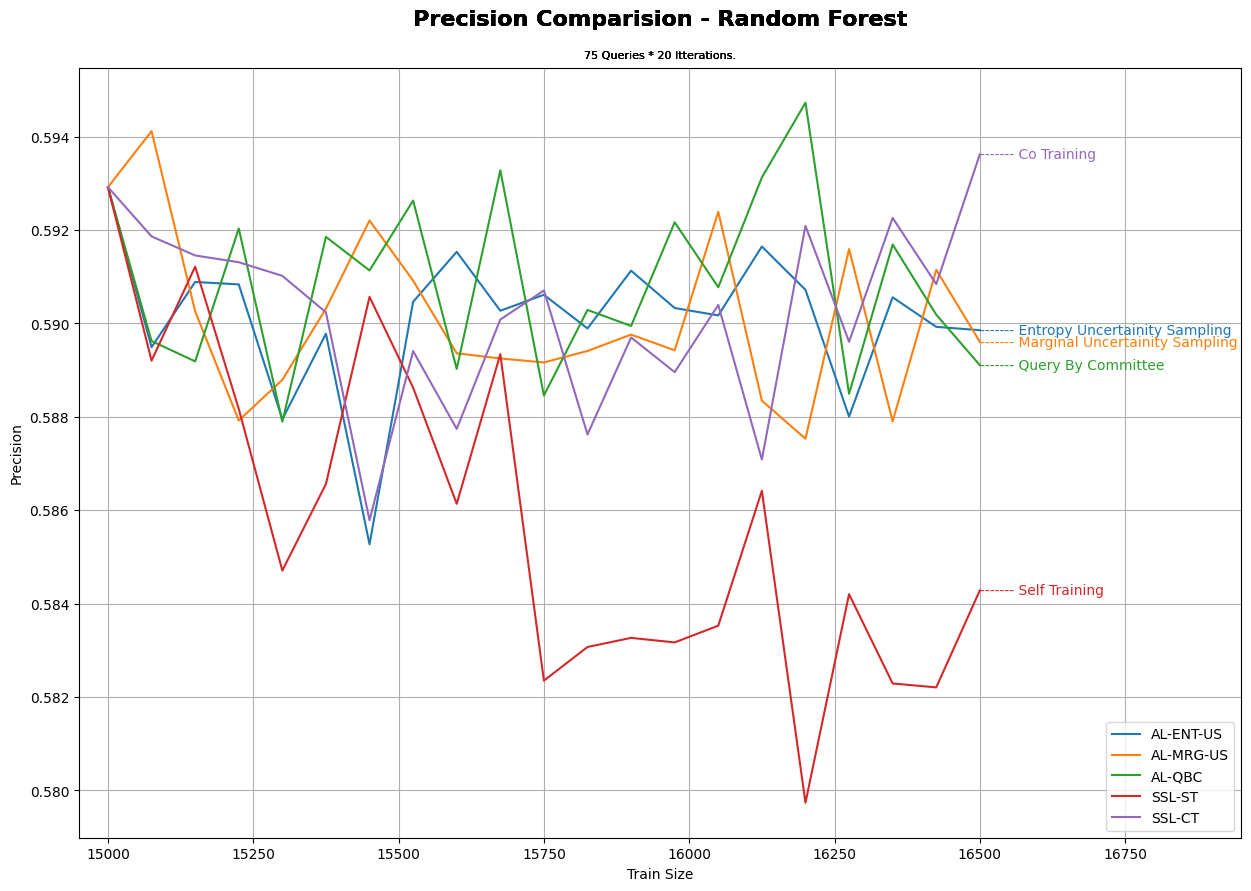

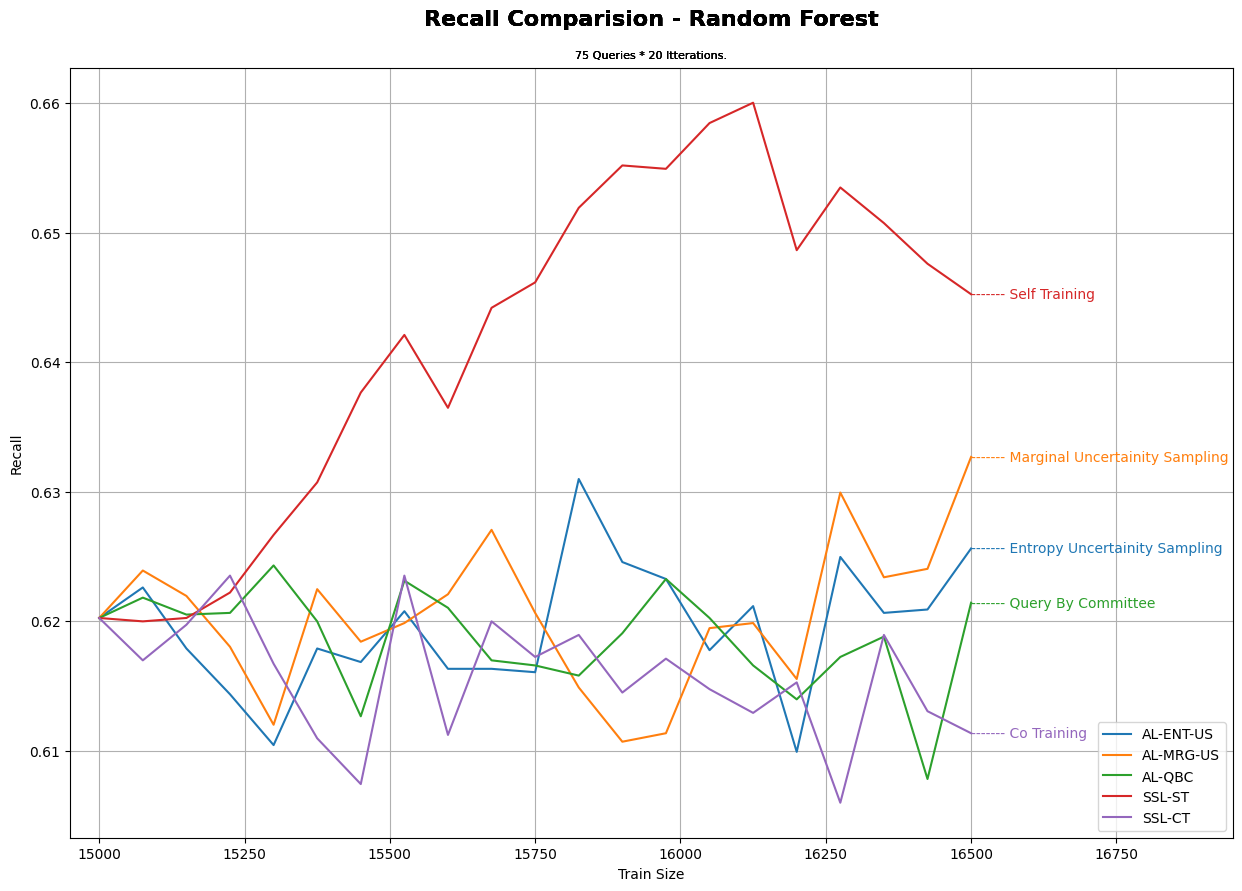

In [ ]:
import matplotlib.pyplot as plt

methods = {"Entropy Uncertainity Sampling":" - AL - ",
           "Marginal Uncertainity Sampling":" - AL - ",
          "Query By Committee":" - AL - ",
           "Self Training":" - SSL - ",
           "Co Training":" - SSL - "}
directory = "Malware Prediction/result/"
model = "Random Forest"
# model = "XGBoost"

itterations = 20
n_queries = 1500//itterations


metric = ["Accuracy","F1_Score","Precision","Recall"]
for target in metric:
    fig, ax = plt.subplots(figsize=(15,10))
    for method, name in methods.items():

        title = model + name + method +  " - Results"
        file_name = directory + title + "nq_" + str(n_queries) +"-iter_"+str(itterations) + "-Results.csv"
        df = pd.read_csv(file_name)
        df = df.sort_values(by='Train Size', ascending=True)
        x = df["Train Size"].values
        y = df[target].values
        line, = ax.plot(x, y, label=method)
        color = line.get_color()
        ax.annotate(xy=(x[-1],y[-1]), xytext=(0,0), textcoords='offset points', text="------- " + method, va='center', color = color)
        ax.set_xlabel('Train Size')
        ax.set_ylabel(target)
        ax.set_xlim(left=min(x) - 50, right=max(x) + 450)
        # ax.set_ylim(bottom = 0.58, top= 0.61)

        ax.text(x=0.5, y=1.05, s= target + " Comparision - "+ model, fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
        ax.text(x=0.5, y=1.01, s=str(n_queries) + " Queries * " + str(itterations) + " Itterations.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)


    plt.legend(["AL-ENT-US", "AL-MRG-US", "AL-QBC", "SSL-ST","SSL-CT"], loc ="lower right")
    plt.grid(True)
    plt.savefig( "Malware Prediction/"+target + " Comparision - " + model + " - " + target + "nq_" + str(n_queries) +"-iter_"+str(itterations)+".png")
    plt.show()
